In [ ]:
# !pip yfinance -q

ERROR: unknown command "yfinance"


In [ ]:
import yfinance as yf
import random 
import numpy as np
import pandas as pd
import random
import numpy as np
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
import os
import gc
from matplotlib import pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%matplotlib inline


### **Stock Indicators**

In [182]:
def technical_indicators(df):
  df['Volume']=df['Volume']/1000000
  df_close=df['Close']
  df_close=pd.DataFrame(df_close, columns=['Close'])
  df11=df_close.reset_index()
  #RSI
  df11['change'] = df11['Close'].diff()
  df['change']=df11['change']
    #SMA  #30days
  df['SMA10'] = df11['Close'].rolling(30).mean()
    #EMA
  df11['EWMA30'] = df11['Close'].ewm(span=10).mean()

  # df['delta']=(df['change']>0)*1.
  def rma(x, n):
      """Running moving average"""
      a = np.full_like(x, np.nan)
      a[n] = x[1:n+1].mean()
      for i in range(n+1, len(x)):
          a[i] = (a[i-1] * (n - 1) + x[i]) / n
      return a

  df11['gain'] = df11.change.mask(df11.change < 0, 0.0)
  df11['loss'] = -df11.change.mask(df11.change > 0, -0.0)
  df11['avg_gain'] = rma(df11.gain.to_numpy(), 14)        
  df11['avg_loss'] = rma(df11.loss.to_numpy(), 14)     
  df11['rs'] = df11.avg_gain / df11.avg_loss
  df11['rsi'] = 100 - (100 / (1 + df11.rs))

   #stochastic oscillator
  df['14-high'] = df['High'].rolling(14).max()
  df['14-low'] = df['Low'].rolling(14).min()
  df['%K'] = (df['Close'] - df['14-low'])*100/(df['14-high'] - df['14-low'])
  df['%D'] = df['%K'].rolling(3).mean() 

  #MACD
  k = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
  d = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
  macd = k - d
  macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()
  macd_h = macd - macd_s

  df['macd'] = df.index.map(macd)
  # df['macd_h'] = df.index.map(macd_h)
  # df['macd_s'] = df.index.map(macd_s)
  #   #A/D
  # df['cmfv'] = ((df['Close']-df['Low'])-(df['High']-df['Close']))/df['High']-df['Low']*df['Volume']
  # df['A/D'] = df['cmfv'].cumsum()/1000

    #OBV
  df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
  #ROC
  N=df['Close'].diff(13)
  D=df['Close'].shift(13)
  df['ROC'] = pd.Series(100*N/D)

  #william R
  highh = df['High'].rolling(14).max() 
  lowl = df['Low'].rolling(14).min()
  df['wr'] = -100 * ((highh - df['Close']) / (highh - lowl))

  #disparity index
  ma = df['Close'].rolling(14).mean()
  df['disparity'] = ((df['Close'] - ma) / ma) * 1000


  df11.drop(columns=['Close','change','index','gain','loss','avg_gain','avg_loss','rs'], inplace=True)
  df_cat=pd.concat([df, df11], axis=1)
  df_cat.fillna(method='bfill', axis=0, inplace=True)
  df_cat.fillna(method='ffill', axis=0, inplace=True)
  return df_cat

dir=["JPM"]
dfs=[]
for i in range(len(dir)):
  Stock = pd.read_csv(dir[i]+".csv")
  USED_LENGTH=int(0.4*len(Stock))
  Stock = (Stock.iloc[USED_LENGTH:]).reset_index()    #only use generate prediction
  df=technical_indicators(Stock).drop(columns=['Date','Adj Close','index'])
  dfs.append(df)


print("Used length", USED_LENGTH)
assert(len(dfs)==len(dir))

FEATURE=dfs[0].shape[-1]
print(FEATURE)
print(dfs[0].columns)
dfs[0]


Used length 1341
18
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'change', 'SMA10', '14-high',
       '14-low', '%K', '%D', 'macd', 'obv', 'ROC', 'wr', 'disparity', 'EWMA30',
       'rsi'],
      dtype='object')


,Open,High,Low,Close,Volume,change,SMA10,14-high,14-low,%K,%D,macd,obv,ROC,wr,disparity,EWMA30,rsi
0,63.680000,64.870003,63.639999,64.720001,14.9725,-0.319999,66.271333,67.190002,63.250000,86.294423,76.988167,0.454400,0.0000,2.982078,-13.705577,16.614947,64.720001,66.294191
1,64.510002,65.320000,64.290001,64.400002,17.6924,-0.319999,66.271333,67.190002,63.250000,86.294423,76.988167,0.454400,-17.6924,2.982078,-13.705577,16.614947,64.544002,66.294191
2,64.529999,65.070000,63.419998,63.919998,18.0879,-0.480004,66.271333,67.190002,63.250000,86.294423,76.988167,0.454400,-35.7803,2.982078,-13.705577,16.614947,64.293156,66.294191
3,63.669998,64.599998,63.250000,64.500000,15.0399,0.580002,66.271333,67.190002,63.250000,86.294423,76.988167,0.454400,-20.7404,2.982078,-13.705577,16.614947,64.361302,66.294191
4,64.970001,65.650002,64.599998,65.489998,16.8026,0.989998,66.271333,67.190002,63.250000,86.294423,76.988167,0.454400,-3.9378,2.982078,-13.705577,16.614947,64.685320,66.294191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,140.460007,141.100006,140.039993,140.729996,7.5675,0.190003,131.456666,141.779999,126.220001,93.251908,93.016259,2.287346,-512.8848,9.585733,-6.748092,47.621557,137.667015,66.196089
2008,139.600006,139.960007,137.630005,137.669998,10.6293,-3.059998,131.670666,141.779999,126.220001,73.586108,86.289608,2.178712,-523.5141,7.883392,-26.413892,19.826333,137.667557,57.013358
2009,137.619995,137.809998,134.000000,135.229996,14.4161,-2.440002,131.691000,141.779999,126.220001,57.904860,74.914292,1.874128,-537.9302,6.087703,-42.095140,-2.271394,137.224364,50.944705
2010,136.000000,137.910004,135.660004,137.050003,9.0411,1.820007,131.984000,141.779999,126.220001,69.601564,67.030844,1.759322,-528.8891,7.162408,-30.398436,6.077288,137.192662,54.808713


In [183]:
#Normalize time series
# Scalers = [ StandardScaler() for _ in range(len(dfs)) ]
dfs_standard=[]
for i in range(len(dfs)):
  dataset_standard = dfs[i]#Scalers[i].fit_transform(dfs[i])
  dfs_standard.append(dataset_standard)

print(dfs_standard[0].shape)

(2012, 18)


<ipython-input-184-8b6e80b885b3>:4: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("JPM",xy=(0,80),textcoords='offset points', fontsize=20)


Text(0, 80, 'JPM')

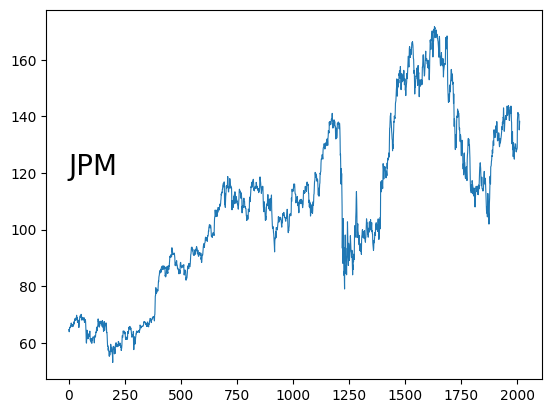

In [184]:
stock_price_array=np.array(dfs_standard[0])[:,3]   #Price   3
plt.plot(stock_price_array, linewidth=0.8)

plt.annotate("JPM",xy=(0,80),textcoords='offset points', fontsize=20)

In [185]:
stock_price_array=np.array(dfs_standard[0])[:,3]
stock_array=np.array(dfs_standard[0])
print(stock_array.shape)

(2012, 18)


### **Train Test Split**

1307
X_train length 1307
X_test length 705


<ipython-input-186-09be09bfe4de>:18: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("JPM",xy=(0,80),textcoords='offset points', fontsize=20)


Text(0, 80, 'JPM')

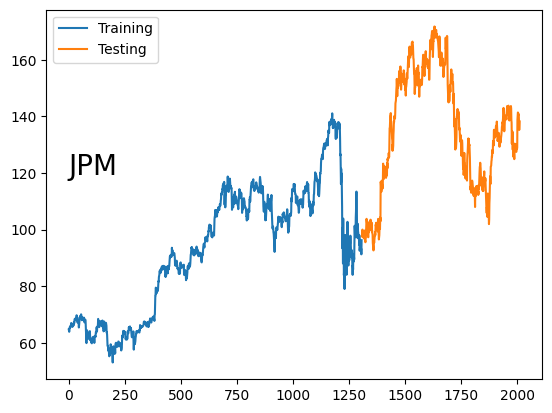

In [186]:
used_length=int(len(stock_array)*0.65)

stock_price_train=stock_price_array[:used_length]

stock_train=stock_array.copy()[:used_length]

stock_price_test=stock_price_array[used_length:]
stock_test=stock_array[used_length:]

print(used_length)

print("X_train length", len(stock_train))
print("X_test length", len(stock_test))

plt.plot(stock_price_train,label='Training')
plt.plot(np.arange(len(stock_price_train),len(stock_array)),stock_price_test, label='Testing')
plt.legend()
plt.annotate("JPM",xy=(0,80),textcoords='offset points', fontsize=20)

### **Stock Delta**

In [187]:
stock_delta_train= np.diff(stock_price_train, n=1, append=stock_price_train[-1])
stock_delta_test= np.diff(stock_price_test, n=1, append=stock_price_train[-1])
print(stock_price_train)
stock_delta_train


[64.720001 64.400002 63.919998 ... 93.300003 91.279999 96.269997]


array([-0.319999, -0.480004,  0.580002, ..., -2.020004,  4.989998,
        0.      ])

### **Use Transformer Generated Prediction**

In [188]:
stock_train.shape

(1307, 18)

In [189]:
transformer_pred = np.array(pd.read_csv("JPM_Pred.csv"))[USED_LENGTH:, 1:]
print(transformer_pred.shape)
transformer_pred_train=transformer_pred[:used_length]
transformer_pred_test=transformer_pred[used_length:]

print("pred train len",transformer_pred_train.shape)
print("pred test len",transformer_pred_test.shape)

(2012, 7)
pred train len (1307, 7)
pred test len (705, 7)


In [190]:
pred_delta_train= np.diff(transformer_pred_train, n=1, append=transformer_pred_train[:,-1:])
pred_delta_test= np.diff(transformer_pred_test, n=1, append=transformer_pred_test[:,-1:])
print(transformer_pred_train)
print(transformer_pred_train.shape)
print(pred_delta_train.shape)
pred_delta_train


[[61.763775 61.804462 61.772667 ... 61.707977 61.61629  61.59091 ]
 [62.274536 62.21454  62.00877  ... 61.99668  61.96086  62.209698]
 [63.071022 62.76545  62.85564  ... 62.790283 63.058266 62.943954]
 ...
 [93.9224   95.42417  95.94953  ... 96.52806  96.826515 96.2763  ]
 [95.30153  95.63262  96.02139  ... 96.432106 95.80766  96.23775 ]
 [96.04523  96.54553  96.7242   ... 96.19799  96.62367  96.17693 ]]
(1307, 7)
(1307, 7)


array([[ 0.040687, -0.031795, -0.127712, ..., -0.091687, -0.02538 ,
         0.      ],
       [-0.059996, -0.20577 ,  0.05374 , ..., -0.03582 ,  0.248838,
         0.      ],
       [-0.305572,  0.09019 , -0.001773, ...,  0.267983, -0.114312,
         0.      ],
       ...,
       [ 1.50177 ,  0.52536 ,  0.42406 , ...,  0.298455, -0.550215,
         0.      ],
       [ 0.33109 ,  0.38877 ,  0.209216, ..., -0.624446,  0.43009 ,
         0.      ],
       [ 0.5003  ,  0.17867 ,  0.223226, ...,  0.42568 , -0.44674 ,
         0.      ]])

### **Visualize Actual & Prediction & Trading Signals**

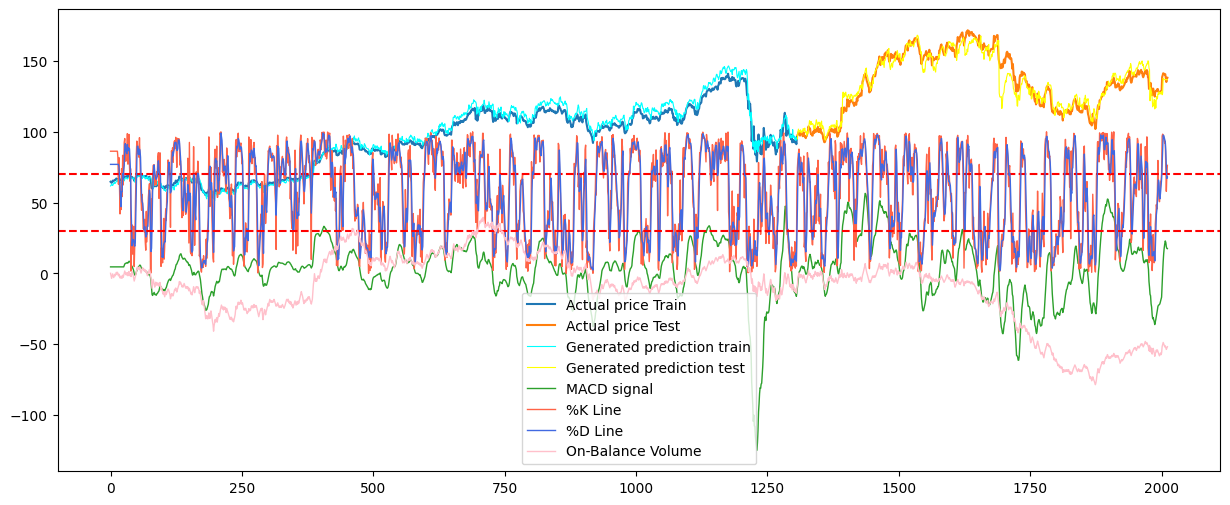

In [222]:
plt.figure(figsize=(15,6))
plt.plot(stock_price_train,label='Actual price Train')
plt.plot(np.arange(len(stock_price_train),len(stock_price_train)+len(stock_price_test)),stock_price_test,label='Actual price Test')
plt.plot(transformer_pred_train[:,0], label='Generated prediction train',linewidth=0.8, color='cyan')
plt.plot(np.arange(len(stock_price_train),len(stock_price_train)+len(stock_price_test)),transformer_pred_test[:,0], label='Generated prediction test',linewidth=0.8, color='yellow')

#MACD  
plt.plot(stock_array[:,11]*10, label="MACD signal",linewidth=1)

#Stochastic Oscillator
plt.plot(stock_array[:,9], label="%K Line",linewidth=1, color='tomato')
plt.axhline(y = 70, color = 'r', linestyle = '--')
plt.plot(stock_array[:,10], label="%D Line",linewidth=1, color='royalblue')
plt.axhline(y = 30, color = 'r', linestyle = '--')
# Bullish Signal: When the %K line crosses above the %D line and both lines are in the oversold region (below 20), 
# it indicates a potential buying opportunity. It suggests that positive momentum is increasing, and the price may start to rise.
# Bearish Signal: When the %K line crosses below the %D line and both lines are in the overbought region (above 80), 
# it indicates a potential selling opportunity. It suggests that negative momentum is increasing, and the price may start to decline.

plt.plot(stock_array[:,12]/10, label="On-Balance Volume",linewidth=1, color='pink')
#Bullish Signal: When the OBV line starts rising, it suggests that buying volume is increasing, indicating potential upward price movement. This is considered a bullish signal, indicating a potential buying opportunity.
#Bearish Signal: When the OBV line starts declining, it suggests that selling volume is increasing, indicating potential downward price movement. This is considered a bearish signal, indicating a potential selling opportunity.

plt.legend()

In [ ]:
stock_price_train.max()

141.089996

In [ ]:
transformer_pred[0]   #each day we have a window of prediction of next 7 days

array([61.763775, 61.804462, 61.772667, 61.644955, 61.707977, 61.61629 ,
       61.59091 ])

### **Create Trading Game**

In [421]:
TRANSACTION=0.0001
CONTEXT=15
LOOK_FORWARD=3
class Game:  # Create tradin game step day by day through the stock, look at a window of prices, and try to make actions at each timestep
    def __init__(self, w=CONTEXT, stock=stock_train, stock_price=stock_price_train, 
                 stock_delta=stock_delta_train, stock_pred_price=transformer_pred_train, pred_delta=pred_delta_train):
        self.w = w #window size
        self.stock=stock
        self.stock_price=stock_price
        self.stock_pred_price=stock_pred_price
        self.stock_delta=stock_delta_train
        self.pred_delta=pred_delta_train
        self.reset() 


    def reset(self):
        # restart game, initialize game state
        self.money=100000     #Initial Money
        self.positions=10000   #Initial Shares holding

        self.today=CONTEXT-LOOK_FORWARD-1      #30- 7-1   =22           past:0~22,      today:22 ,     future:23~29 
        self.inital_property=self.positions*self.stock_price[self.today]+self.money  #initial total investment = 10,000 shares + cash

        
        self.window_right=self.w-1   #29
        self.window_left=0         
        
        self.today_price = self.stock_price[self.today]        
        self.window = self.stock_price[ self.window_left:self.today+1] #price    0~14

        self.window_all=self.stock[ self.window_left:self.today+1]  #22 features
        
        self.previous_reward=0  #to store and plot the mean reward during each game to see if improves
        self.yesterday_property= self.inital_property
        self.profit=0 
        
        
        self.money_record=[self.money]*CONTEXT
        self.positions_record=[self.positions]*CONTEXT
        self.actions_record=[0]*CONTEXT

        self.money_window=self.money_record[self.window_left:self.today+1]
        self.positions_window=self.positions_record[self.window_left:self.today+1]
        self.actions_window=self.actions_record[self.window_left:self.today+1]

        self.window_pred=self.stock_pred_price[self.today,:LOOK_FORWARD]   # transformer predictions


        self.window_delta_past=self.stock_delta[self.window_left:self.today+1]
        self.window_delta_pred=self.pred_delta[self.today,:LOOK_FORWARD]

    def play_step(self, action):
        self.yesterday_price=self.money
        self.yesterday_property=(self.money + self.today_price*self.positions )

        # 2. make a move, compute money, update positions
        self.money=self.money - self.today_price * action
         #update positions
        self.positions += action     #shares in hand

        self.money_record.append(self.money)
        self.positions_record.append(self.positions)
        self.actions_record.append(action)

        self.today += 1  # update the head and window
        self.today_price=self.stock_price[self.today] 
        #Move window forward
        self.window_left += 1 
        self.window_right += 1 

        self.window=self.stock_price[self.window_left:self.today+1]       # past prices 

        self.window_all=self.stock[self.window_left:self.today+1]         # past indicators

        self.window_pred=self.stock_pred_price[self.today+1,:LOOK_FORWARD]              # predicted price

        self.window_delta_past=self.stock_delta[self.window_left:self.today+1] #past delta
        self.window_delta_pred=self.pred_delta[self.today,:LOOK_FORWARD]                #predicted delta

        self.money_window=self.money_record[self.window_left:self.today+1]# past money recode
        self.positions_window=self.positions_record[self.window_left:self.today+1]#past position record
        self.actions_window=self.actions_record[self.window_left:self.today+1]

        
        reward=0
                #The reward function will be defined as the difference between the portfolio value 
        #at the end of the time step and the portfolio value at the beginning of the time step.
        #TODO: Carefully DESIGN it, to help agent mimick experts' trading strategy first before letting it go

        reward= (self.money + self.today_price*self.positions ) - self.yesterday_property            -  abs(action)*TRANSACTION
        reward += 1*(self.window_pred.mean()- self.window_pred[0]) * action 
        # reward = reward+ 20*(self.window_delta_pred.mean() - self.window_delta_past[-7:].mean()) * action
        reward += 0.2*( -100*self.window_all[-1,11] ) * action #MACD

        reward += 200.*( self.window_all[-1,9]> self.window_all[-1,10])* (action>0) * (self.window_all[-1,9]<30)*(self.window_all[-1,10]<30)
        reward += 200.*( self.window_all[-1,9]< self.window_all[-1,10])* (action<0) * (self.window_all[-1,9]>70)*(self.window_all[-1,10]>70)

#curriculum1: if future > today, and you buy today, then reward the agent, vice versa for sell
#curriculum2: if future delta > past delta, buy today get reward 
#curriculum3: if MACD(11) drop too low and perform bottom fishing buy, then reward 
#             if MACD too high and sell at peek, then reward
#curriculum 4:
# Bullish Signal: When the %K line(9) crosses above the %D(10) line and both lines are in the oversold region (below 20), 
# it indicates a potential buying opportunity. It suggests that positive momentum is increasing, and the price may start to rise.
# Bearish Signal: When the %K line crosses below the %D line and both lines are in the overbought region (above 80), 
# it indicates a potential selling opportunity. It suggests that negative momentum is increasing, and the price may start to decline.
        # 3. check if game over
        game_over = False
        if self.is_collision():
            game_over = True
            #calculate profit at the end of each game
            self.profit= ((self.money + self.today_price*self.positions )-self.inital_property) /self.inital_property  #profitability at the end of each game
            return reward, game_over

        return reward, game_over

    def is_collision(self):
        # hits boundary 
        if self.window_right>len(self.stock_price)-2:
            return 1
        return 0


In [422]:
stock_train.shape

(1307, 18)

### **Define State, Action Space**

In [423]:
STATE_SIZE=3+ stock_train.shape[-1] #Position and Money, Action(3) + Indicator's feature dimension(22)
print("State size:", STATE_SIZE)  
ACTION_SPACE=np.arange(-4000,4001,500).tolist()    #Actions
ACTION_SIZE=len(ACTION_SPACE)
print("Action_size:", ACTION_SIZE)
print("Action_space:", ACTION_SPACE)

State size: 21
Action_size: 17
Action_space: [-4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]


### **Build Double Q leaning**

In [424]:
MAX_MEMORY = 20000 # record 20000 experiences, carefully tune this
BATCH_SIZE = 512
criterion = nn.SmoothL1Loss()
LR = 0.001
GAMMA=0.995
TAU=0.7
Q_UPDATE_FREQ=5
#Qnet for a given state action pair gives value
class QNetwork(nn.Module):
    def __init__(self, state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_size=128):
        super(QNetwork, self).__init__()
        # CNN scans for features : State embedding
        self.embedding=nn.Sequential(
        nn.Conv1d(state_size, hidden_size, kernel_size=3, stride=1, padding=1, bias=False ),
        # nn.LayerNorm([hidden_size, CONTEXT]),
        nn.GELU(),
        nn.BatchNorm1d(hidden_size),

        nn.Conv1d(hidden_size, hidden_size, kernel_size=3, stride=1, padding=1, bias=False ),
        # nn.LayerNorm([hidden_size, CONTEXT]),
        nn.BatchNorm1d(hidden_size),
        )

        self.blstm = torch.nn.LSTM(hidden_size, hidden_size, bias=True, batch_first=True, dropout=0.1, bidirectional=True)

        self.fc=nn.Sequential(
            
        nn.Linear(hidden_size*2, hidden_size*2),
        nn.GELU(),
        nn.Linear(hidden_size*2, hidden_size),
        nn.GELU(),
        nn.Linear(hidden_size, hidden_size),
        nn.GELU()
        )
        self.Linear_out=nn.Linear(hidden_size * CONTEXT, action_size)
    def forward(self, x):
        # batch * time * feature --->  batch * feature * time for CNN       512, 256, 20
        out=self.embedding(torch.transpose(x,1,2)) 
        out=torch.transpose(out,1,2) # Permute back for Linear layers

        out,_ = self.blstm(out)
        out=self.fc(out)
        #predict Q values for each Action 
        out=self.Linear_out(    out.flatten(start_dim=1)   )
        return out

class DoubleDQN:
    def __init__(self, state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_size=256, lr=LR, tau=TAU,
                 q_update_freq=Q_UPDATE_FREQ, 
                 ):
        self.q_net = QNetwork(state_size, action_size, hidden_size).to(device)
        self.target_q_net = QNetwork(state_size, action_size, hidden_size).to(device)
        self.target_q_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.tau = tau
        self.total_steps=0
        self.q_update_freq=q_update_freq

    def soft_update(self):
        if self.total_steps % self.q_update_freq==0:
          for target_param, param in zip(self.target_q_net.parameters(), self.q_net.parameters()): #soft copy Q1's params over 
              target_param.data.copy_(self.tau * param.data + (1-self.tau) * target_param.data)

    def train_step(self, state, action, reward, next_state, done):
      self.total_steps += 1

      states_tensor = torch.FloatTensor(state).to(device)  #batch_size * state_size 
      actions_tensor = torch.LongTensor(action).to(device)  #batch_size
      rewards_tensor = torch.FloatTensor(reward).to(device) #batch_size
      next_states_tensor = torch.FloatTensor(next_state).to(device)  #batch_size * state_size 
      dones_tensor = torch.BoolTensor(done).to(device)  #batch_size

      with torch.no_grad():
        q_next=self.target_q_net(next_states_tensor) #use 2-Qnet to estimate target Q      #batch_size * action_size
        max_q_next,_ = torch.max(q_next, dim=1)     #bach_size
        q_target = rewards_tensor + GAMMA * max_q_next * (~dones_tensor)   # Bellman Equation    batch_size

      q_pred = self.q_net(states_tensor)    #use 1-Qnet to get current Q rped     #batch_size * action)size
      actions_index=[]
      for b in range(BATCH_SIZE):
        actions_index.append(ACTION_SPACE.index(actions_tensor[b]))     
      actions_index=torch.LongTensor(actions_index).to(device)    #convert action played to action index for DQN
      #get Q value corresponds to the action played
      q_values_pred_selected = q_pred.gather(1, actions_index.unsqueeze(1)).squeeze(1)    #batch_size * action_size

      loss = criterion(q_values_pred_selected, q_target) /(BATCH_SIZE)      #Temporal Difference   

      self.optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 1e+8)
      self.optimizer.step()

      self.soft_update()  #soft update Double Q

      return loss.item()

### **Create Agent that play the game and sample experiences to train**

In [425]:
class Agent:
    def __init__(self):
        self.n_games = 0
        self.trainer = DoubleDQN()
        self.memory = deque(maxlen=MAX_MEMORY) # a collection of past experiences 


    def get_state(self, game):

        window_all=np.array(game.window_all )
        money_window=(np.array(game.money_window)/10000).reshape(-1,1)   #your money
        positions_window=(np.array(game.positions_window)/100).reshape(-1,1)
        actions_window=(np.array(game.actions_window)/100).reshape(-1,1)

        
        pred_window = np.array(game.window_pred ).reshape(-1,1)

        assert(game.money>=0.0)     #make sure money doesn't got to negative
        assert(game.positions>=0.0) #make sure positions doesn't go to negative

        state= np.concatenate( [positions_window, money_window, actions_window, window_all], axis=-1  ) # 23, 24    #Concate Feature with Pos+Money

        pred_window_repeat=np.repeat(pred_window, state.shape[-1], axis=-1)   #7, 24   #Prediction broadcasting

        state=np.concatenate([state, pred_window_repeat], axis=0)   #30, 24     #Concate Past + Future
        # print(state.shape)
        return state

    def remember(self, state, action, reward, next_state, done):
        # state=(state- np.mean(state,axis=0))/np.std(state,axis=0) #normalize
        reward/=100
        self.memory.append((state, action, reward, next_state, done)) # Deque popleft if MAX_MEMORY is reached


    def train_batch_experience(self):

        if len(self.memory) >= BATCH_SIZE:
            batch_sample = random.sample(self.memory, BATCH_SIZE)  # list of tuples
            #pass in batch to train
            states, actions, rewards, next_states, dones = zip(*batch_sample)
            # print("states", states.shape)
            loss=self.trainer.train_step(states, actions, rewards, next_states, dones)
            return loss
        return 0.
    def train_short_experience(self, batch_size=32):

        if len(self.memory) >= BATCH_SIZE:
            batch_sample = random.sample(self.memory, batch_size)  # list of tuples
            #pass in batch to train
            states, actions, rewards, next_states, dones = zip(*batch_sample)
            # print("states", states.shape)
            loss=self.trainer.train_step(states, actions, rewards, next_states, dones)
            return loss
        return 0.
            
    def get_action(self, state, game):    # e p s i l o n greedy---------------------------------------------------------------------------------
        #80% possibility of taking random action. decrease in time
        self.epsilon = 80 - self.n_games//5   #6 games reduce 1% chance of choosing action other than the best action
        if self.epsilon<10:
          self.epsilon=10 #not allowing below 10%  randomness
        position=game.positions
        money=game.money

        today_price=game.today_price

        final_move=0.
        #Explore random actions
        if random.randint(0, 100) < max(self.epsilon,0) or (len(self.memory) <= BATCH_SIZE):
            actions=np.array(ACTION_SPACE)
            final_move=np.random.choice(actions)  
            #cannot buy more than the money you have, find closest value in the action space
            if final_move>0 and final_move*today_price >= money:
              for a in reversed(ACTION_SPACE): # find action that doesn't use up all your money in action space
                if a>=0 and a*today_price < money:
                  return a
              
            if final_move<0 and final_move<-position:    
              for a in ACTION_SPACE:  #find action that doesn't sell all your shares in action space
                if a<=0 and a+position>=0:
                  return a
#===================================================================================================================================
        #Take max q action
        else:
            state_input = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(device)  #observe
            Q_pred= self.trainer.q_net(state_input)    #USE QNet to get actions' value
            move = torch.argmax(Q_pred).item()         #Find best action index
            #allowable=np.clip(move, -position, money//today_price)    
            final_move=ACTION_SPACE[move]   #Map Argmax index to action
        #Clip Action!! 
            #cannot buy more than the money you have, find closest value in the action space
            if final_move>0 and final_move*today_price > money:
              for a in reversed(ACTION_SPACE):
                if a>=0 and a*today_price< money: #find action that doesn't use up all your money in action space
                  # print("action", a, today_price, money)
                  return a
            
            if final_move<0 and final_move<-position:   
              for a in ACTION_SPACE: #find action that doesn't sell all your shares in action space
                if a<=0 and a+position>=0:
                  return a

        if final_move>0 and final_move*today_price >= money:    
          return 0.
        if final_move<0 and final_move<-position:
          return 0.
        return final_move

actions=[]
plot_profit=[]
plot_reward=[]
plot_loss=[]
agent = Agent()  #create agent 
def train():
    rewards = []
    record = 0
    #create game on Training set
    game = Game()
    epoch=400000 #a very large number just to keep the game running
    optimizer=agent.trainer.optimizer
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=stock_price_train.shape[0]*3, gamma=0.995)
    for i in tqdm( range(1,epoch+1) ):
        
        curr_lr = float(optimizer.param_groups[0]['lr'])  
        state_old = agent.get_state(game)            #observe 
        action = agent.get_action(state_old, game)   #action
        actions.append(action)
        reward, done= game.play_step(action)         #get reward
#--------------------------------------------------------------------------------------------------------------------
        state_new = agent.get_state(game)            #observe again
        # memory stored for replay
        agent.remember(state_old, action, reward, state_new, done)   #store Experience
        # loss=agent.train_short_experience(32)

        rewards.append(reward)     
        profit=game.profit    

        if done:
            mean_reward=np.mean(rewards)
            plot_reward.append(mean_reward)
            rewards=[]
            # train minibatch
            # for i in range(2):
            loss=agent.train_batch_experience()
            plot_loss.append(loss)
            game.reset()
            agent.n_games += 1
            
            if profit > record:
                record = profit
               # agent.model.save()

            print('Game', agent.n_games,"mean Reward", round(mean_reward,2), 'Profit', round(profit*100,2) ,'Record:', round(record*100,2), "eps",agent.epsilon,"lr",round(curr_lr,6), "loss", round(loss,6))

            plot_profit.append(profit)
        scheduler.step()


In [426]:
# from google.colab import drive
# drive.mount('/content/drive')

In [427]:
# PATH = "/content/drive/MyDrive/checkpoint01"
# torch.save(agent.trainer.q_net.state_dict(), PATH)

In [428]:
gc.collect()
torch.cuda.empty_cache()

### **Train and see Rewards and Profits**

In [429]:
train()
#profit is the percentage of cumulated money through the money over money that I had in hand before the game
#mean reward is the average daily dollar returns in each game

  0%|          | 1503/400000 [00:00<04:34, 1452.88it/s]

Game 1 mean Reward 759.7 Profit 44.65 Record: 44.65 eps 80 lr 0.001 loss 0.733395


  1%|          | 2911/400000 [00:01<05:18, 1245.09it/s]

Game 2 mean Reward 1273.36 Profit 18.53 Record: 44.65 eps 80 lr 0.001 loss 0.73915


  1%|          | 4115/400000 [00:02<05:09, 1277.97it/s]

Game 3 mean Reward 1631.36 Profit 33.82 Record: 44.65 eps 80 lr 0.001 loss 0.893816


  1%|▏         | 5477/400000 [00:03<04:50, 1359.89it/s]

Game 4 mean Reward 187.46 Profit 24.77 Record: 44.65 eps 80 lr 0.000995 loss 0.709395


  2%|▏         | 6655/400000 [00:04<05:08, 1274.83it/s]

Game 5 mean Reward 145.76 Profit 0.73 Record: 44.65 eps 80 lr 0.000995 loss 0.717198


  2%|▏         | 8019/400000 [00:05<05:05, 1284.58it/s]

Game 6 mean Reward 71.16 Profit -4.79 Record: 44.65 eps 79 lr 0.000995 loss 0.669981


  2%|▏         | 9403/400000 [00:06<04:59, 1303.96it/s]

Game 7 mean Reward 411.99 Profit 9.45 Record: 44.65 eps 79 lr 0.00099 loss 0.691337


  3%|▎         | 10690/400000 [00:07<05:21, 1210.41it/s]

Game 8 mean Reward -836.25 Profit -28.45 Record: 44.65 eps 79 lr 0.00099 loss 0.712139


  3%|▎         | 11936/400000 [00:08<04:47, 1348.01it/s]

Game 9 mean Reward 745.23 Profit 23.33 Record: 44.65 eps 79 lr 0.00099 loss 0.740763


  3%|▎         | 13100/400000 [00:08<05:19, 1209.16it/s]

Game 10 mean Reward 2778.01 Profit 82.65 Record: 82.65 eps 79 lr 0.000985 loss 0.749577


  4%|▎         | 14414/400000 [00:10<06:36, 973.57it/s]

Game 11 mean Reward 1245.14 Profit 26.71 Record: 82.65 eps 78 lr 0.000985 loss 0.826415


  4%|▍         | 15752/400000 [00:11<07:54, 809.79it/s]

Game 12 mean Reward -98.67 Profit 3.28 Record: 82.65 eps 78 lr 0.000985 loss 0.652767


  4%|▍         | 17045/400000 [00:12<05:49, 1094.78it/s]

Game 13 mean Reward -1006.55 Profit -23.88 Record: 82.65 eps 78 lr 0.00098 loss 0.707462


  5%|▍         | 18252/400000 [00:13<05:16, 1205.58it/s]

Game 14 mean Reward 383.55 Profit 1.89 Record: 82.65 eps 78 lr 0.00098 loss 0.706124


  5%|▍         | 19584/400000 [00:14<05:14, 1208.08it/s]

Game 15 mean Reward 654.2 Profit 16.76 Record: 82.65 eps 78 lr 0.00098 loss 0.734458


  5%|▌         | 20961/400000 [00:15<05:35, 1131.21it/s]

Game 16 mean Reward -51.15 Profit -1.91 Record: 82.65 eps 77 lr 0.000975 loss 0.632762


  6%|▌         | 22289/400000 [00:16<05:04, 1238.89it/s]

Game 17 mean Reward -456.95 Profit -24.43 Record: 82.65 eps 77 lr 0.000975 loss 0.624971


  6%|▌         | 23570/400000 [00:17<05:11, 1208.03it/s]

Game 18 mean Reward 619.14 Profit 12.52 Record: 82.65 eps 77 lr 0.000975 loss 0.630127


  6%|▌         | 24835/400000 [00:18<05:06, 1224.43it/s]

Game 19 mean Reward 88.99 Profit 4.26 Record: 82.65 eps 77 lr 0.00097 loss 0.51529


  7%|▋         | 26155/400000 [00:19<05:12, 1196.61it/s]

Game 20 mean Reward -198.37 Profit 2.9 Record: 82.65 eps 77 lr 0.00097 loss 0.654338


  7%|▋         | 27466/400000 [00:20<05:47, 1073.19it/s]

Game 21 mean Reward 105.94 Profit 21.55 Record: 82.65 eps 76 lr 0.00097 loss 0.781514


  7%|▋         | 28563/400000 [00:21<06:12, 997.09it/s]

Game 22 mean Reward 497.1 Profit 20.71 Record: 82.65 eps 76 lr 0.000966 loss 0.683353


  7%|▋         | 29972/400000 [00:22<05:08, 1198.00it/s]

Game 23 mean Reward 451.9 Profit 17.75 Record: 82.65 eps 76 lr 0.000966 loss 0.705163


  8%|▊         | 31112/400000 [00:23<07:48, 787.09it/s]

Game 24 mean Reward -1224.45 Profit -18.16 Record: 82.65 eps 76 lr 0.000966 loss 0.655091


  8%|▊         | 32449/400000 [00:24<07:52, 777.61it/s]

Game 25 mean Reward 118.01 Profit -6.74 Record: 82.65 eps 76 lr 0.000961 loss 0.544268


  8%|▊         | 33844/400000 [00:25<05:22, 1135.11it/s]

Game 26 mean Reward -1081.82 Profit -32.01 Record: 82.65 eps 75 lr 0.000961 loss 1.0496


  9%|▉         | 35064/400000 [00:26<05:27, 1112.82it/s]

Game 27 mean Reward 1461.65 Profit 52.86 Record: 82.65 eps 75 lr 0.000961 loss 0.934698


  9%|▉         | 36429/400000 [00:27<05:32, 1092.39it/s]

Game 28 mean Reward -226.05 Profit -2.75 Record: 82.65 eps 75 lr 0.000956 loss 0.870129


  9%|▉         | 37759/400000 [00:28<05:13, 1154.61it/s]

Game 29 mean Reward -214.82 Profit -12.12 Record: 82.65 eps 75 lr 0.000956 loss 0.906716


 10%|▉         | 39059/400000 [00:29<05:40, 1059.86it/s]

Game 30 mean Reward 849.39 Profit 37.03 Record: 82.65 eps 75 lr 0.000956 loss 0.825108


 10%|█         | 40318/400000 [00:30<05:51, 1024.13it/s]

Game 31 mean Reward 391.01 Profit 4.76 Record: 82.65 eps 74 lr 0.000951 loss 1.55988


 10%|█         | 41622/400000 [00:31<05:37, 1060.54it/s]

Game 32 mean Reward 764.71 Profit 3.77 Record: 82.65 eps 74 lr 0.000951 loss 1.319745


 11%|█         | 42817/400000 [00:32<05:37, 1059.26it/s]

Game 33 mean Reward 352.85 Profit 7.76 Record: 82.65 eps 74 lr 0.000951 loss 1.144005


 11%|█         | 44132/400000 [00:33<05:23, 1099.62it/s]

Game 34 mean Reward 29.26 Profit 27.21 Record: 82.65 eps 74 lr 0.000946 loss 1.040575


 11%|█▏        | 45435/400000 [00:34<06:25, 920.35it/s]

Game 35 mean Reward 51.59 Profit 23.21 Record: 82.65 eps 74 lr 0.000946 loss 0.934698


 12%|█▏        | 46676/400000 [00:36<08:43, 675.19it/s]

Game 36 mean Reward 477.39 Profit 18.28 Record: 82.65 eps 73 lr 0.000946 loss 1.738992


 12%|█▏        | 47981/400000 [00:37<06:33, 893.74it/s]

Game 37 mean Reward 492.89 Profit 16.7 Record: 82.65 eps 73 lr 0.000942 loss 1.311825


 12%|█▏        | 49294/400000 [00:38<05:48, 1005.81it/s]

Game 38 mean Reward -264.93 Profit 8.58 Record: 82.65 eps 73 lr 0.000942 loss 1.16834


 13%|█▎        | 50591/400000 [00:39<05:46, 1007.10it/s]

Game 39 mean Reward 665.38 Profit 10.18 Record: 82.65 eps 73 lr 0.000942 loss 1.161251


 13%|█▎        | 51845/400000 [00:40<05:48, 998.07it/s]

Game 40 mean Reward -454.55 Profit 6.63 Record: 82.65 eps 73 lr 0.000937 loss 1.134184


 13%|█▎        | 52904/400000 [00:41<04:18, 1342.06it/s]

Game 41 mean Reward 94.36 Profit 14.13 Record: 82.65 eps 72 lr 0.000937 loss 1.667835


 14%|█▎        | 54511/400000 [00:43<07:22, 781.08it/s]

Game 42 mean Reward 158.04 Profit 28.81 Record: 82.65 eps 72 lr 0.000937 loss 1.532724


 14%|█▍        | 55704/400000 [00:45<06:27, 888.21it/s]

Game 43 mean Reward 766.67 Profit 23.48 Record: 82.65 eps 72 lr 0.000932 loss 1.195178


 14%|█▍        | 57060/400000 [00:46<05:54, 968.46it/s]

Game 44 mean Reward 2403.51 Profit 84.53 Record: 84.53 eps 72 lr 0.000932 loss 1.109946


 15%|█▍        | 58251/400000 [00:47<07:47, 730.77it/s]

Game 45 mean Reward 1228.05 Profit 49.13 Record: 84.53 eps 72 lr 0.000932 loss 1.192653


 15%|█▍        | 59559/400000 [00:49<09:07, 622.31it/s]

Game 46 mean Reward -312.88 Profit 0.52 Record: 84.53 eps 71 lr 0.000928 loss 1.724301


 15%|█▌        | 60972/400000 [00:50<05:50, 966.61it/s]

Game 47 mean Reward 951.0 Profit 28.97 Record: 84.53 eps 71 lr 0.000928 loss 1.363206


 16%|█▌        | 62156/400000 [00:51<05:55, 949.38it/s]

Game 48 mean Reward -326.72 Profit 19.42 Record: 84.53 eps 71 lr 0.000928 loss 1.326519


 16%|█▌        | 63444/400000 [00:52<05:53, 950.78it/s]

Game 49 mean Reward -149.87 Profit -3.21 Record: 84.53 eps 71 lr 0.000923 loss 1.374514


 16%|█▌        | 64863/400000 [00:53<05:29, 1016.30it/s]

Game 50 mean Reward 283.92 Profit 19.23 Record: 84.53 eps 71 lr 0.000923 loss 1.230708


 17%|█▋        | 66165/400000 [00:54<05:39, 983.25it/s]

Game 51 mean Reward 253.89 Profit 29.68 Record: 84.53 eps 70 lr 0.000923 loss 1.921631


 17%|█▋        | 67389/400000 [00:55<06:15, 886.68it/s]

Game 52 mean Reward -451.01 Profit 13.2 Record: 84.53 eps 70 lr 0.000918 loss 2.258708


 17%|█▋        | 68617/400000 [00:57<06:09, 897.07it/s]

Game 53 mean Reward 520.22 Profit 22.35 Record: 84.53 eps 70 lr 0.000918 loss 1.3989


 17%|█▋        | 69898/400000 [00:58<05:49, 943.79it/s]

Game 54 mean Reward 513.11 Profit 24.07 Record: 84.53 eps 70 lr 0.000918 loss 1.771989


 18%|█▊        | 71189/400000 [00:59<06:34, 834.07it/s]

Game 55 mean Reward 788.43 Profit 33.01 Record: 84.53 eps 70 lr 0.000914 loss 2.080525


 18%|█▊        | 72476/400000 [01:01<09:05, 600.06it/s]

Game 56 mean Reward 370.66 Profit 10.29 Record: 84.53 eps 69 lr 0.000914 loss 2.361191


 18%|█▊        | 73891/400000 [01:02<05:31, 984.72it/s]

Game 57 mean Reward 488.89 Profit 19.49 Record: 84.53 eps 69 lr 0.000914 loss 1.99332


 19%|█▉        | 75153/400000 [01:03<05:19, 1015.90it/s]

Game 58 mean Reward 2305.7 Profit 56.55 Record: 84.53 eps 69 lr 0.000909 loss 2.054273


 19%|█▉        | 76506/400000 [01:04<05:30, 978.34it/s]

Game 59 mean Reward 884.12 Profit 43.46 Record: 84.53 eps 69 lr 0.000909 loss 1.893552


 19%|█▉        | 77652/400000 [01:05<05:45, 932.58it/s]

Game 60 mean Reward 799.74 Profit 18.42 Record: 84.53 eps 69 lr 0.000909 loss 1.704033


 20%|█▉        | 79079/400000 [01:06<05:32, 964.22it/s]

Game 61 mean Reward 1149.92 Profit 52.71 Record: 84.53 eps 68 lr 0.000905 loss 2.084772


 20%|██        | 80235/400000 [01:07<05:27, 977.29it/s]

Game 62 mean Reward 617.56 Profit 0.45 Record: 84.53 eps 68 lr 0.000905 loss 1.96741


 20%|██        | 81539/400000 [01:09<06:05, 871.44it/s] 

Game 63 mean Reward 421.25 Profit 26.98 Record: 84.53 eps 68 lr 0.000905 loss 1.780837


 21%|██        | 82798/400000 [01:10<06:34, 804.51it/s] 

Game 64 mean Reward 549.85 Profit 18.02 Record: 84.53 eps 68 lr 0.0009 loss 1.837639


 21%|██        | 84201/400000 [01:11<05:25, 969.75it/s]

Game 65 mean Reward 2053.26 Profit 51.41 Record: 84.53 eps 68 lr 0.0009 loss 1.843662


 21%|██▏       | 85435/400000 [01:13<10:35, 494.75it/s]

Game 66 mean Reward 1470.11 Profit 36.06 Record: 84.53 eps 67 lr 0.0009 loss 2.345679


 22%|██▏       | 86816/400000 [01:14<05:56, 878.39it/s]

Game 67 mean Reward 775.3 Profit 14.9 Record: 84.53 eps 67 lr 0.000896 loss 1.895557


 22%|██▏       | 88098/400000 [01:16<05:40, 915.63it/s]

Game 68 mean Reward 1010.75 Profit 1.78 Record: 84.53 eps 67 lr 0.000896 loss 1.795563


 22%|██▏       | 89352/400000 [01:17<05:43, 905.54it/s]

Game 69 mean Reward 110.83 Profit 19.66 Record: 84.53 eps 67 lr 0.000896 loss 1.985577


 23%|██▎       | 90672/400000 [01:18<05:49, 885.73it/s]

Game 70 mean Reward 26.39 Profit -13.37 Record: 84.53 eps 67 lr 0.000891 loss 1.781225


 23%|██▎       | 91958/400000 [01:19<05:20, 960.74it/s]

Game 71 mean Reward -40.35 Profit -15.29 Record: 84.53 eps 66 lr 0.000891 loss 2.393335


 23%|██▎       | 93187/400000 [01:20<05:47, 881.73it/s]

Game 72 mean Reward -48.53 Profit -24.9 Record: 84.53 eps 66 lr 0.000891 loss 2.642541


 24%|██▎       | 94523/400000 [01:22<05:22, 947.39it/s]

Game 73 mean Reward 2796.67 Profit 65.16 Record: 84.53 eps 66 lr 0.000887 loss 1.871624


 24%|██▍       | 95746/400000 [01:23<05:40, 894.27it/s]

Game 74 mean Reward -771.93 Profit -25.42 Record: 84.53 eps 66 lr 0.000887 loss 2.252307


 24%|██▍       | 97029/400000 [01:24<06:49, 739.32it/s]

Game 75 mean Reward 851.73 Profit 34.21 Record: 84.53 eps 66 lr 0.000887 loss 2.153361


 25%|██▍       | 98332/400000 [01:26<08:53, 565.59it/s]

Game 76 mean Reward 537.92 Profit 1.75 Record: 84.53 eps 65 lr 0.000882 loss 2.091801


 25%|██▍       | 99667/400000 [01:27<05:00, 1000.98it/s]

Game 77 mean Reward 37.59 Profit -19.44 Record: 84.53 eps 65 lr 0.000882 loss 2.662914


 25%|██▌       | 100957/400000 [01:28<05:22, 928.69it/s]

Game 78 mean Reward 400.1 Profit 2.25 Record: 84.53 eps 65 lr 0.000882 loss 2.691223


 26%|██▌       | 102256/400000 [01:29<05:53, 843.41it/s]

Game 79 mean Reward 745.9 Profit 24.27 Record: 84.53 eps 65 lr 0.000878 loss 2.259901


 26%|██▌       | 103470/400000 [01:31<06:23, 772.69it/s] 

Game 80 mean Reward -408.53 Profit 6.84 Record: 84.53 eps 65 lr 0.000878 loss 2.346423


 26%|██▌       | 104812/400000 [01:32<05:53, 834.34it/s]

Game 81 mean Reward 522.84 Profit 30.46 Record: 84.53 eps 64 lr 0.000878 loss 2.43587


 27%|██▋       | 106089/400000 [01:33<05:53, 831.22it/s]

Game 82 mean Reward -397.8 Profit -20.62 Record: 84.53 eps 64 lr 0.000873 loss 2.502993


 27%|██▋       | 107390/400000 [01:34<05:49, 838.33it/s]

Game 83 mean Reward 556.14 Profit 15.48 Record: 84.53 eps 64 lr 0.000873 loss 2.511231


 27%|██▋       | 108762/400000 [01:36<05:06, 948.93it/s]

Game 84 mean Reward 1293.93 Profit 24.15 Record: 84.53 eps 64 lr 0.000873 loss 2.114798


 27%|██▋       | 109948/400000 [01:37<08:35, 562.72it/s]

Game 85 mean Reward 644.36 Profit 8.33 Record: 84.53 eps 64 lr 0.000869 loss 2.247128


 28%|██▊       | 111253/400000 [01:39<07:18, 658.06it/s]

Game 86 mean Reward -6.4 Profit 1.89 Record: 84.53 eps 63 lr 0.000869 loss 2.486164


 28%|██▊       | 112622/400000 [01:40<05:51, 817.46it/s]

Game 87 mean Reward 8.16 Profit 13.83 Record: 84.53 eps 63 lr 0.000869 loss 2.491405


 28%|██▊       | 113896/400000 [01:41<05:37, 847.28it/s]

Game 88 mean Reward 1190.47 Profit 30.05 Record: 84.53 eps 63 lr 0.000869 loss 2.450176


 29%|██▉       | 115256/400000 [01:43<05:16, 901.00it/s]

Game 89 mean Reward 650.67 Profit 10.61 Record: 84.53 eps 63 lr 0.000865 loss 2.251924


 29%|██▉       | 116421/400000 [01:44<05:35, 846.34it/s]

Game 90 mean Reward 1326.18 Profit 35.46 Record: 84.53 eps 63 lr 0.000865 loss 2.677805


 29%|██▉       | 117776/400000 [01:45<05:53, 799.40it/s]

Game 91 mean Reward 1167.67 Profit 38.07 Record: 84.53 eps 62 lr 0.000865 loss 2.871505


 30%|██▉       | 119115/400000 [01:46<05:29, 852.28it/s]

Game 92 mean Reward 160.12 Profit -24.17 Record: 84.53 eps 62 lr 0.00086 loss 3.568974


 30%|███       | 120326/400000 [01:48<05:47, 804.75it/s]

Game 93 mean Reward 310.71 Profit -1.27 Record: 84.53 eps 62 lr 0.00086 loss 2.908308


 30%|███       | 121603/400000 [01:49<08:05, 572.98it/s]

Game 94 mean Reward 2384.78 Profit 30.77 Record: 84.53 eps 62 lr 0.00086 loss 3.106839


 31%|███       | 122871/400000 [01:51<07:14, 637.57it/s]

Game 95 mean Reward 1189.82 Profit 9.17 Record: 84.53 eps 62 lr 0.000856 loss 3.018686


 31%|███       | 124159/400000 [01:52<05:51, 784.61it/s]

Game 96 mean Reward 4182.13 Profit 59.31 Record: 84.53 eps 61 lr 0.000856 loss 3.111446


 31%|███▏      | 125557/400000 [01:54<05:31, 827.39it/s]

Game 97 mean Reward 1651.66 Profit 15.3 Record: 84.53 eps 61 lr 0.000856 loss 3.119502


 32%|███▏      | 126749/400000 [01:55<05:36, 812.29it/s]

Game 98 mean Reward 821.81 Profit 4.19 Record: 84.53 eps 61 lr 0.000852 loss 3.183233


 32%|███▏      | 128094/400000 [01:56<05:37, 806.65it/s]

Game 99 mean Reward 2578.06 Profit 30.39 Record: 84.53 eps 61 lr 0.000852 loss 3.583402


 32%|███▏      | 129333/400000 [01:57<05:18, 850.98it/s]

Game 100 mean Reward 2264.21 Profit 53.86 Record: 84.53 eps 61 lr 0.000852 loss 3.496954


 33%|███▎      | 130680/400000 [01:59<05:22, 836.37it/s]

Game 101 mean Reward 3049.5 Profit 65.45 Record: 84.53 eps 60 lr 0.000848 loss 3.766414


 33%|███▎      | 131900/400000 [02:00<05:29, 813.18it/s]

Game 102 mean Reward 1814.81 Profit 29.5 Record: 84.53 eps 60 lr 0.000848 loss 3.643636


 33%|███▎      | 133214/400000 [02:02<07:27, 596.43it/s]

Game 103 mean Reward 783.25 Profit 6.15 Record: 84.53 eps 60 lr 0.000848 loss 3.354027


 34%|███▎      | 134534/400000 [02:03<08:19, 531.38it/s]

Game 104 mean Reward 2275.74 Profit 58.68 Record: 84.53 eps 60 lr 0.000843 loss 3.150801


 34%|███▍      | 135780/400000 [02:05<06:01, 731.58it/s]

Game 105 mean Reward 1729.51 Profit 37.84 Record: 84.53 eps 60 lr 0.000843 loss 3.202674


 34%|███▍      | 137131/400000 [02:06<05:52, 745.10it/s]

Game 106 mean Reward 1068.31 Profit 3.22 Record: 84.53 eps 59 lr 0.000843 loss 3.137785


 35%|███▍      | 138460/400000 [02:08<05:37, 774.05it/s]

Game 107 mean Reward 1307.02 Profit 11.03 Record: 84.53 eps 59 lr 0.000839 loss 3.456662


 35%|███▍      | 139755/400000 [02:09<05:32, 783.65it/s]

Game 108 mean Reward 3395.5 Profit 60.54 Record: 84.53 eps 59 lr 0.000839 loss 3.96112


 35%|███▌      | 140970/400000 [02:10<05:10, 834.93it/s]

Game 109 mean Reward 3548.76 Profit 72.55 Record: 84.53 eps 59 lr 0.000839 loss 4.111006


 36%|███▌      | 142258/400000 [02:12<05:40, 757.46it/s]

Game 110 mean Reward 2589.36 Profit 29.63 Record: 84.53 eps 59 lr 0.000835 loss 3.340217


 36%|███▌      | 143596/400000 [02:13<05:52, 727.25it/s]

Game 111 mean Reward 2250.25 Profit 55.7 Record: 84.53 eps 58 lr 0.000835 loss 3.827102


 36%|███▌      | 144790/400000 [02:15<08:30, 499.82it/s]

Game 112 mean Reward 3484.08 Profit 65.44 Record: 84.53 eps 58 lr 0.000835 loss 3.961308


 37%|███▋      | 146171/400000 [02:16<05:47, 731.08it/s]

Game 113 mean Reward 1955.87 Profit 29.59 Record: 84.53 eps 58 lr 0.000831 loss 4.115486


 37%|███▋      | 147399/400000 [02:18<06:12, 677.78it/s] 

Game 114 mean Reward 1876.29 Profit 20.74 Record: 84.53 eps 58 lr 0.000831 loss 3.774394


 37%|███▋      | 148714/400000 [02:19<05:28, 764.30it/s]

Game 115 mean Reward 720.88 Profit 11.1 Record: 84.53 eps 58 lr 0.000831 loss 3.397745


 37%|███▋      | 149973/400000 [02:21<06:35, 631.80it/s] 

Game 116 mean Reward 1077.33 Profit 20.48 Record: 84.53 eps 57 lr 0.000827 loss 4.520364


 38%|███▊      | 151310/400000 [02:22<05:24, 765.79it/s]

Game 117 mean Reward 1612.4 Profit 51.6 Record: 84.53 eps 57 lr 0.000827 loss 3.683464


 38%|███▊      | 152637/400000 [02:23<05:45, 715.33it/s]

Game 118 mean Reward 1694.6 Profit 56.71 Record: 84.53 eps 57 lr 0.000827 loss 3.531109


 38%|███▊      | 153970/400000 [02:25<04:55, 831.30it/s]

Game 119 mean Reward 2022.17 Profit 71.69 Record: 84.53 eps 57 lr 0.000822 loss 3.605732


 39%|███▉      | 155177/400000 [02:27<12:14, 333.39it/s]

Game 120 mean Reward 1247.28 Profit 22.82 Record: 84.53 eps 57 lr 0.000822 loss 3.835447


 39%|███▉      | 156511/400000 [02:29<05:53, 689.44it/s]

Game 121 mean Reward 1909.37 Profit 50.31 Record: 84.53 eps 56 lr 0.000822 loss 3.991149


 39%|███▉      | 157794/400000 [02:31<05:36, 719.70it/s]

Game 122 mean Reward 976.87 Profit 25.15 Record: 84.53 eps 56 lr 0.000818 loss 4.616346


 40%|███▉      | 159023/400000 [02:32<06:01, 666.88it/s]

Game 123 mean Reward 1654.36 Profit 49.73 Record: 84.53 eps 56 lr 0.000818 loss 3.806244


 40%|████      | 160410/400000 [02:34<05:31, 723.30it/s]

Game 124 mean Reward 2305.12 Profit 33.9 Record: 84.53 eps 56 lr 0.000818 loss 3.85565


 40%|████      | 161635/400000 [02:35<05:25, 731.56it/s]

Game 125 mean Reward 4477.14 Profit 93.58 Record: 93.58 eps 56 lr 0.000814 loss 4.049032


 41%|████      | 162945/400000 [02:37<05:15, 750.59it/s]

Game 126 mean Reward 2927.59 Profit 42.62 Record: 93.58 eps 55 lr 0.000814 loss 4.749791


 41%|████      | 164223/400000 [02:38<05:48, 676.25it/s]

Game 127 mean Reward 3063.15 Profit 50.56 Record: 93.58 eps 55 lr 0.000814 loss 4.231857


 41%|████▏     | 165533/400000 [02:40<08:01, 486.53it/s]

Game 128 mean Reward 2984.76 Profit 21.9 Record: 93.58 eps 55 lr 0.00081 loss 4.122524


 42%|████▏     | 166759/400000 [02:42<05:52, 661.74it/s]

Game 129 mean Reward 4454.66 Profit 73.86 Record: 93.58 eps 55 lr 0.00081 loss 4.655361


 42%|████▏     | 168067/400000 [02:43<05:23, 716.37it/s]

Game 130 mean Reward 3666.6 Profit 45.08 Record: 93.58 eps 55 lr 0.00081 loss 6.399866


 42%|████▏     | 169433/400000 [02:45<05:05, 755.19it/s]

Game 131 mean Reward 2536.18 Profit 22.22 Record: 93.58 eps 54 lr 0.000806 loss 4.681839


 43%|████▎     | 170716/400000 [02:46<05:21, 713.66it/s]

Game 132 mean Reward 1568.71 Profit 24.51 Record: 93.58 eps 54 lr 0.000806 loss 5.753751


 43%|████▎     | 171998/400000 [02:47<05:28, 694.93it/s]

Game 133 mean Reward 2801.19 Profit 27.35 Record: 93.58 eps 54 lr 0.000806 loss 5.618062


 43%|████▎     | 173263/400000 [02:49<05:12, 724.71it/s]

Game 134 mean Reward 1070.98 Profit -17.57 Record: 93.58 eps 54 lr 0.000802 loss 4.910521


 44%|████▎     | 174608/400000 [02:50<05:30, 682.28it/s]

Game 135 mean Reward 2781.17 Profit 27.18 Record: 93.58 eps 54 lr 0.000802 loss 6.435135


 44%|████▍     | 175806/400000 [02:52<07:16, 513.87it/s]

Game 136 mean Reward 4958.05 Profit 70.23 Record: 93.58 eps 53 lr 0.000802 loss 5.079757


 44%|████▍     | 177176/400000 [02:54<05:21, 692.57it/s]

Game 137 mean Reward 4276.96 Profit 59.67 Record: 93.58 eps 53 lr 0.000798 loss 5.274822


 45%|████▍     | 178435/400000 [02:56<05:22, 687.08it/s]

Game 138 mean Reward 3522.84 Profit 45.04 Record: 93.58 eps 53 lr 0.000798 loss 4.837854


 45%|████▍     | 179678/400000 [02:57<05:14, 700.35it/s]

Game 139 mean Reward 2751.22 Profit 26.8 Record: 93.58 eps 53 lr 0.000798 loss 6.230457


 45%|████▌     | 181049/400000 [02:59<05:14, 696.39it/s]

Game 140 mean Reward 2623.87 Profit 39.44 Record: 93.58 eps 53 lr 0.000794 loss 6.53675


 46%|████▌     | 182269/400000 [03:00<05:23, 672.95it/s]

Game 141 mean Reward 3846.84 Profit 62.53 Record: 93.58 eps 52 lr 0.000794 loss 4.241261


 46%|████▌     | 183648/400000 [03:02<05:08, 700.55it/s]

Game 142 mean Reward 3695.76 Profit 50.59 Record: 93.58 eps 52 lr 0.000794 loss 4.906545


 46%|████▌     | 184863/400000 [03:03<05:38, 635.83it/s]

Game 143 mean Reward 3357.71 Profit 18.76 Record: 93.58 eps 52 lr 0.00079 loss 4.838145


 47%|████▋     | 186141/400000 [03:05<07:26, 478.96it/s]

Game 144 mean Reward 1904.22 Profit 13.08 Record: 93.58 eps 52 lr 0.00079 loss 4.463151


 47%|████▋     | 187438/400000 [03:07<05:31, 640.50it/s]

Game 145 mean Reward 4147.96 Profit 50.01 Record: 93.58 eps 52 lr 0.00079 loss 5.044238


 47%|████▋     | 188740/400000 [03:08<05:07, 686.47it/s]

Game 146 mean Reward 2982.11 Profit 19.29 Record: 93.58 eps 51 lr 0.000786 loss 5.383907


 48%|████▊     | 190093/400000 [03:10<04:49, 725.75it/s]

Game 147 mean Reward 3317.43 Profit 27.33 Record: 93.58 eps 51 lr 0.000786 loss 4.774471


 48%|████▊     | 191414/400000 [03:11<05:06, 679.50it/s]

Game 148 mean Reward 2287.03 Profit 31.39 Record: 93.58 eps 51 lr 0.000786 loss 4.864704


 48%|████▊     | 192620/400000 [03:13<05:02, 685.62it/s]

Game 149 mean Reward 2519.38 Profit 33.3 Record: 93.58 eps 51 lr 0.000782 loss 4.885653


 48%|████▊     | 193930/400000 [03:14<05:12, 660.25it/s]

Game 150 mean Reward 3335.86 Profit 34.22 Record: 93.58 eps 51 lr 0.000782 loss 4.895525


 49%|████▉     | 195195/400000 [03:16<06:38, 513.82it/s]

Game 151 mean Reward 1575.44 Profit -13.9 Record: 93.58 eps 50 lr 0.000782 loss 4.847291


 49%|████▉     | 196510/400000 [03:18<06:44, 503.14it/s]

Game 152 mean Reward 1290.75 Profit -18.39 Record: 93.58 eps 50 lr 0.000778 loss 4.875695


 49%|████▉     | 197771/400000 [03:20<05:12, 646.98it/s]

Game 153 mean Reward 3996.95 Profit 39.87 Record: 93.58 eps 50 lr 0.000778 loss 4.696886


 50%|████▉     | 199110/400000 [03:21<04:52, 686.43it/s]

Game 154 mean Reward 2599.51 Profit 29.95 Record: 93.58 eps 50 lr 0.000778 loss 5.937169


 50%|█████     | 200392/400000 [03:23<04:55, 676.09it/s]

Game 155 mean Reward 3632.57 Profit 42.16 Record: 93.58 eps 50 lr 0.000774 loss 4.599267


 50%|█████     | 201680/400000 [03:24<04:57, 667.43it/s]

Game 156 mean Reward 3419.65 Profit 15.56 Record: 93.58 eps 49 lr 0.000774 loss 5.028042


 51%|█████     | 203024/400000 [03:26<05:15, 624.11it/s]

Game 157 mean Reward 3207.22 Profit 26.12 Record: 93.58 eps 49 lr 0.000774 loss 4.585567


 51%|█████     | 204308/400000 [03:28<04:51, 670.22it/s]

Game 158 mean Reward 3026.0 Profit 22.44 Record: 93.58 eps 49 lr 0.000771 loss 5.019277


 51%|█████▏    | 205550/400000 [03:30<07:33, 428.43it/s]

Game 159 mean Reward 3439.38 Profit 24.93 Record: 93.58 eps 49 lr 0.000771 loss 5.798737


 52%|█████▏    | 206808/400000 [03:31<05:13, 615.42it/s]

Game 160 mean Reward 3505.8 Profit 43.91 Record: 93.58 eps 49 lr 0.000771 loss 6.230059


 52%|█████▏    | 208097/400000 [03:33<05:21, 597.22it/s]

Game 161 mean Reward 3857.46 Profit 35.52 Record: 93.58 eps 48 lr 0.000767 loss 4.040604


 52%|█████▏    | 209509/400000 [03:35<04:45, 666.61it/s]

Game 162 mean Reward 1143.6 Profit -12.12 Record: 93.58 eps 48 lr 0.000767 loss 4.167442


 53%|█████▎    | 210746/400000 [03:36<05:07, 615.70it/s]

Game 163 mean Reward 1355.78 Profit -0.98 Record: 93.58 eps 48 lr 0.000767 loss 4.657144


 53%|█████▎    | 212008/400000 [03:38<04:40, 669.04it/s]

Game 164 mean Reward 3105.25 Profit 29.67 Record: 93.58 eps 48 lr 0.000763 loss 4.730024


 53%|█████▎    | 213328/400000 [03:40<04:52, 638.04it/s]

Game 165 mean Reward 1062.92 Profit -21.34 Record: 93.58 eps 48 lr 0.000763 loss 5.623914


 54%|█████▎    | 214571/400000 [03:42<07:09, 431.45it/s]

Game 166 mean Reward 3623.55 Profit 25.99 Record: 93.58 eps 47 lr 0.000763 loss 4.105779


 54%|█████▍    | 215916/400000 [03:44<05:25, 566.20it/s]

Game 167 mean Reward 3165.76 Profit 33.06 Record: 93.58 eps 47 lr 0.000759 loss 4.635225


 54%|█████▍    | 217173/400000 [03:45<04:51, 626.30it/s]

Game 168 mean Reward 2555.89 Profit 14.76 Record: 93.58 eps 47 lr 0.000759 loss 4.677479


 55%|█████▍    | 218528/400000 [03:47<04:43, 639.44it/s]

Game 169 mean Reward 2269.77 Profit 9.17 Record: 93.58 eps 47 lr 0.000759 loss 4.400607


 55%|█████▍    | 219745/400000 [03:48<04:48, 625.29it/s]

Game 170 mean Reward 879.13 Profit -7.61 Record: 93.58 eps 47 lr 0.000755 loss 4.67291


 55%|█████▌    | 221096/400000 [03:50<04:36, 646.24it/s]

Game 171 mean Reward 3328.42 Profit 38.57 Record: 93.58 eps 46 lr 0.000755 loss 5.106812


 56%|█████▌    | 222321/400000 [03:52<04:43, 626.30it/s]

Game 172 mean Reward 2419.02 Profit 29.63 Record: 93.58 eps 46 lr 0.000755 loss 8.294408


 56%|█████▌    | 223632/400000 [03:54<06:07, 480.32it/s]

Game 173 mean Reward 1512.19 Profit 7.66 Record: 93.58 eps 46 lr 0.000751 loss 5.478853


 56%|█████▌    | 224933/400000 [03:56<05:24, 539.95it/s]

Game 174 mean Reward 2251.08 Profit 2.06 Record: 93.58 eps 46 lr 0.000751 loss 6.194059


 57%|█████▋    | 226185/400000 [03:57<04:56, 585.42it/s]

Game 175 mean Reward 2472.08 Profit 22.71 Record: 93.58 eps 46 lr 0.000751 loss 8.659036


 57%|█████▋    | 227504/400000 [03:59<04:21, 660.76it/s]

Game 176 mean Reward 3262.2 Profit 13.67 Record: 93.58 eps 45 lr 0.000751 loss 6.65507


 57%|█████▋    | 228791/400000 [04:01<04:34, 622.60it/s]

Game 177 mean Reward 4615.8 Profit 48.22 Record: 93.58 eps 45 lr 0.000748 loss 3.885785


 58%|█████▊    | 230069/400000 [04:02<04:31, 626.87it/s]

Game 178 mean Reward 3776.8 Profit 39.45 Record: 93.58 eps 45 lr 0.000748 loss 6.176947


 58%|█████▊    | 231354/400000 [04:04<04:50, 579.68it/s]

Game 179 mean Reward 1446.26 Profit -24.55 Record: 93.58 eps 45 lr 0.000748 loss 5.239961


 58%|█████▊    | 232639/400000 [04:06<06:19, 441.16it/s]

Game 180 mean Reward 1067.67 Profit -9.99 Record: 93.58 eps 45 lr 0.000744 loss 5.238311


 58%|█████▊    | 233969/400000 [04:08<05:30, 502.29it/s]

Game 181 mean Reward 2740.0 Profit 19.32 Record: 93.58 eps 44 lr 0.000744 loss 3.481741


 59%|█████▉    | 235245/400000 [04:10<04:39, 588.84it/s]

Game 182 mean Reward 1721.97 Profit 6.84 Record: 93.58 eps 44 lr 0.000744 loss 5.655054


 59%|█████▉    | 236552/400000 [04:11<04:22, 623.72it/s]

Game 183 mean Reward 909.87 Profit -20.1 Record: 93.58 eps 44 lr 0.00074 loss 5.96969


 59%|█████▉    | 237869/400000 [04:13<04:30, 599.61it/s]

Game 184 mean Reward 2557.46 Profit 20.68 Record: 93.58 eps 44 lr 0.00074 loss 4.839608


 60%|█████▉    | 239137/400000 [04:15<04:30, 595.22it/s]

Game 185 mean Reward 510.21 Profit -30.45 Record: 93.58 eps 44 lr 0.00074 loss 4.331923


 60%|██████    | 240456/400000 [04:16<04:34, 580.67it/s]

Game 186 mean Reward 1956.78 Profit 4.48 Record: 93.58 eps 43 lr 0.000737 loss 4.134352


 60%|██████    | 241711/400000 [04:18<05:45, 458.04it/s]

Game 187 mean Reward 1844.83 Profit 21.06 Record: 93.58 eps 43 lr 0.000737 loss 4.745483


 61%|██████    | 243013/400000 [04:20<05:18, 492.39it/s]

Game 188 mean Reward 1713.79 Profit 0.52 Record: 93.58 eps 43 lr 0.000737 loss 6.665823


 61%|██████    | 244307/400000 [04:22<04:10, 620.99it/s]

Game 189 mean Reward 1568.35 Profit -7.55 Record: 93.58 eps 43 lr 0.000733 loss 4.480972


 61%|██████▏   | 245650/400000 [04:24<04:14, 607.50it/s]

Game 190 mean Reward 662.5 Profit -24.07 Record: 93.58 eps 43 lr 0.000733 loss 4.979714


 62%|██████▏   | 246888/400000 [04:25<04:46, 534.95it/s]

Game 191 mean Reward 680.78 Profit -21.47 Record: 93.58 eps 42 lr 0.000733 loss 4.490492


 62%|██████▏   | 248163/400000 [04:27<04:14, 597.76it/s]

Game 192 mean Reward 1163.09 Profit -1.94 Record: 93.58 eps 42 lr 0.000729 loss 4.179205


 62%|██████▏   | 249535/400000 [04:29<03:58, 629.74it/s]

Game 193 mean Reward 1176.11 Profit -14.46 Record: 93.58 eps 42 lr 0.000729 loss 4.487526


 63%|██████▎   | 250743/400000 [04:31<05:27, 456.13it/s]

Game 194 mean Reward 3576.49 Profit 40.99 Record: 93.58 eps 42 lr 0.000729 loss 4.497728


 63%|██████▎   | 252016/400000 [04:33<04:53, 504.64it/s]

Game 195 mean Reward 3308.53 Profit 26.01 Record: 93.58 eps 42 lr 0.000726 loss 4.098098


 63%|██████▎   | 253368/400000 [04:35<04:24, 555.07it/s]

Game 196 mean Reward 1763.9 Profit -10.42 Record: 93.58 eps 41 lr 0.000726 loss 3.887625


 64%|██████▎   | 254613/400000 [04:37<04:11, 577.75it/s]

Game 197 mean Reward 4840.34 Profit 74.86 Record: 93.58 eps 41 lr 0.000726 loss 3.504831


 64%|██████▍   | 255937/400000 [04:38<04:05, 587.79it/s]

Game 198 mean Reward 4298.28 Profit 44.44 Record: 93.58 eps 41 lr 0.000722 loss 3.33332


 64%|██████▍   | 257231/400000 [04:40<04:12, 565.40it/s]

Game 199 mean Reward 5947.19 Profit 89.08 Record: 93.58 eps 41 lr 0.000722 loss 3.2464


 65%|██████▍   | 258504/400000 [04:42<04:17, 548.69it/s]

Game 200 mean Reward 4353.19 Profit 65.58 Record: 93.58 eps 41 lr 0.000722 loss 3.546343


 65%|██████▍   | 259791/400000 [04:44<05:34, 418.85it/s]

Game 201 mean Reward 4158.82 Profit 51.32 Record: 93.58 eps 40 lr 0.000718 loss 3.953387


 65%|██████▌   | 261115/400000 [04:46<04:19, 535.59it/s]

Game 202 mean Reward 3895.58 Profit 46.54 Record: 93.58 eps 40 lr 0.000718 loss 3.384624


 66%|██████▌   | 262394/400000 [04:48<03:59, 573.60it/s]

Game 203 mean Reward 4189.56 Profit 55.85 Record: 93.58 eps 40 lr 0.000718 loss 3.359843


 66%|██████▌   | 263721/400000 [04:50<04:12, 540.25it/s]

Game 204 mean Reward 3291.89 Profit 39.67 Record: 93.58 eps 40 lr 0.000715 loss 3.057706


 66%|██████▌   | 264945/400000 [04:52<04:17, 524.16it/s]

Game 205 mean Reward 2224.97 Profit 9.14 Record: 93.58 eps 40 lr 0.000715 loss 3.343058


 67%|██████▋   | 266276/400000 [04:53<04:00, 555.37it/s]

Game 206 mean Reward 4695.59 Profit 70.7 Record: 93.58 eps 39 lr 0.000715 loss 3.840521


 67%|██████▋   | 267518/400000 [04:55<04:15, 519.48it/s]

Game 207 mean Reward 3212.86 Profit 25.22 Record: 93.58 eps 39 lr 0.000711 loss 4.333357


 67%|██████▋   | 268865/400000 [04:58<05:28, 399.07it/s]

Game 208 mean Reward 3147.1 Profit 27.25 Record: 93.58 eps 39 lr 0.000711 loss 4.161523


 68%|██████▊   | 270114/400000 [04:59<03:51, 562.03it/s]

Game 209 mean Reward 2983.84 Profit 46.08 Record: 93.58 eps 39 lr 0.000711 loss 3.46962


 68%|██████▊   | 271415/400000 [05:01<03:47, 565.44it/s]

Game 210 mean Reward 3969.48 Profit 39.67 Record: 93.58 eps 39 lr 0.000708 loss 3.706931


 68%|██████▊   | 272772/400000 [05:03<03:36, 587.09it/s]

Game 211 mean Reward 4804.84 Profit 52.77 Record: 93.58 eps 38 lr 0.000708 loss 3.87892


 69%|██████▊   | 274004/400000 [05:05<04:02, 518.76it/s]

Game 212 mean Reward 3439.07 Profit 10.14 Record: 93.58 eps 38 lr 0.000708 loss 3.202572


 69%|██████▉   | 275278/400000 [05:07<03:39, 568.91it/s]

Game 213 mean Reward 4227.29 Profit 33.09 Record: 93.58 eps 38 lr 0.000704 loss 5.676282


 69%|██████▉   | 276551/400000 [05:09<05:16, 390.47it/s]

Game 214 mean Reward 4271.78 Profit 40.02 Record: 93.58 eps 38 lr 0.000704 loss 3.166371


 69%|██████▉   | 277921/400000 [05:11<03:57, 514.74it/s]

Game 215 mean Reward 4660.38 Profit 51.74 Record: 93.58 eps 38 lr 0.000704 loss 3.41426


 70%|██████▉   | 279149/400000 [05:13<04:12, 479.37it/s]

Game 216 mean Reward 5337.63 Profit 61.25 Record: 93.58 eps 37 lr 0.000701 loss 3.929617


 70%|███████   | 280438/400000 [05:15<03:49, 520.86it/s]

Game 217 mean Reward 4623.83 Profit 42.32 Record: 93.58 eps 37 lr 0.000701 loss 3.145202


 70%|███████   | 281746/400000 [05:17<03:48, 517.81it/s]

Game 218 mean Reward 3941.95 Profit 42.51 Record: 93.58 eps 37 lr 0.000701 loss 3.870912


 71%|███████   | 283085/400000 [05:18<03:27, 563.87it/s]

Game 219 mean Reward 4995.06 Profit 48.5 Record: 93.58 eps 37 lr 0.000697 loss 3.217003


 71%|███████   | 284330/400000 [05:20<03:43, 517.14it/s]

Game 220 mean Reward 3791.11 Profit 32.02 Record: 93.58 eps 37 lr 0.000697 loss 2.899327


 71%|███████▏  | 285656/400000 [05:23<04:12, 453.09it/s]

Game 221 mean Reward 4667.0 Profit 56.08 Record: 93.58 eps 36 lr 0.000697 loss 4.392379


 72%|███████▏  | 286960/400000 [05:25<03:34, 526.38it/s]

Game 222 mean Reward 3183.59 Profit 12.04 Record: 93.58 eps 36 lr 0.000694 loss 3.561467


 72%|███████▏  | 288265/400000 [05:26<03:18, 562.67it/s]

Game 223 mean Reward 2728.32 Profit 8.69 Record: 93.58 eps 36 lr 0.000694 loss 3.135854


 72%|███████▏  | 289551/400000 [05:28<03:19, 553.93it/s]

Game 224 mean Reward 2813.86 Profit 14.43 Record: 93.58 eps 36 lr 0.000694 loss 3.492626


 73%|███████▎  | 290803/400000 [05:30<03:23, 535.48it/s]

Game 225 mean Reward 3016.51 Profit 16.73 Record: 93.58 eps 36 lr 0.00069 loss 3.802611


 73%|███████▎  | 292080/400000 [05:32<03:25, 524.00it/s]

Game 226 mean Reward 4889.36 Profit 65.72 Record: 93.58 eps 35 lr 0.00069 loss 3.951436


 73%|███████▎  | 293352/400000 [05:34<04:39, 380.89it/s]

Game 227 mean Reward 3792.94 Profit 45.08 Record: 93.58 eps 35 lr 0.00069 loss 3.96553


 74%|███████▎  | 294697/400000 [05:36<03:14, 540.56it/s]

Game 228 mean Reward 4887.78 Profit 74.49 Record: 93.58 eps 35 lr 0.000687 loss 3.756383


 74%|███████▍  | 295956/400000 [05:38<03:20, 520.14it/s]

Game 229 mean Reward 3705.61 Profit 42.21 Record: 93.58 eps 35 lr 0.000687 loss 3.152858


 74%|███████▍  | 297249/400000 [05:40<03:09, 541.16it/s]

Game 230 mean Reward 5117.7 Profit 73.19 Record: 93.58 eps 35 lr 0.000687 loss 3.750931


 75%|███████▍  | 298602/400000 [05:42<03:11, 528.74it/s]

Game 231 mean Reward 5088.31 Profit 72.52 Record: 93.58 eps 34 lr 0.000683 loss 3.555243


 75%|███████▍  | 299896/400000 [05:44<03:08, 530.82it/s]

Game 232 mean Reward 5547.09 Profit 70.37 Record: 93.58 eps 34 lr 0.000683 loss 3.978811


 75%|███████▌  | 301113/400000 [05:46<04:37, 356.61it/s]

Game 233 mean Reward 4746.31 Profit 52.31 Record: 93.58 eps 34 lr 0.000683 loss 3.804683


 76%|███████▌  | 302454/400000 [05:48<03:14, 500.44it/s]

Game 234 mean Reward 6405.88 Profit 96.01 Record: 96.01 eps 34 lr 0.00068 loss 4.945734


 76%|███████▌  | 303748/400000 [05:50<02:58, 540.04it/s]

Game 235 mean Reward 5093.37 Profit 68.91 Record: 96.01 eps 34 lr 0.00068 loss 4.250255


 76%|███████▋  | 305015/400000 [05:52<02:58, 530.88it/s]

Game 236 mean Reward 6890.21 Profit 96.35 Record: 96.35 eps 33 lr 0.00068 loss 4.013032


 77%|███████▋  | 306319/400000 [05:54<02:51, 544.84it/s]

Game 237 mean Reward 4655.22 Profit 64.54 Record: 96.35 eps 33 lr 0.000676 loss 3.023259


 77%|███████▋  | 307603/400000 [05:56<02:48, 547.87it/s]

Game 238 mean Reward 7559.87 Profit 110.9 Record: 110.9 eps 33 lr 0.000676 loss 4.163938


 77%|███████▋  | 308854/400000 [05:58<04:15, 356.88it/s]

Game 239 mean Reward 5734.12 Profit 84.91 Record: 110.9 eps 33 lr 0.000676 loss 3.815767


 78%|███████▊  | 310153/400000 [06:00<03:06, 482.48it/s]

Game 240 mean Reward 4642.58 Profit 54.42 Record: 110.9 eps 33 lr 0.000673 loss 3.521388


 78%|███████▊  | 311448/400000 [06:02<02:49, 521.69it/s]

Game 241 mean Reward 4432.48 Profit 59.5 Record: 110.9 eps 32 lr 0.000673 loss 3.495649


 78%|███████▊  | 312798/400000 [06:04<02:47, 519.74it/s]

Game 242 mean Reward 4844.76 Profit 70.19 Record: 110.9 eps 32 lr 0.000673 loss 3.24735


 79%|███████▊  | 314102/400000 [06:06<02:49, 506.96it/s]

Game 243 mean Reward 6670.06 Profit 104.0 Record: 110.9 eps 32 lr 0.00067 loss 4.846308


 79%|███████▉  | 315380/400000 [06:08<02:41, 523.91it/s]

Game 244 mean Reward 4249.96 Profit 48.29 Record: 110.9 eps 32 lr 0.00067 loss 4.351975


 79%|███████▉  | 316606/400000 [06:10<03:11, 435.94it/s]

Game 245 mean Reward 4650.56 Profit 46.63 Record: 110.9 eps 32 lr 0.00067 loss 4.391487


 79%|███████▉  | 317979/400000 [06:13<02:47, 488.50it/s]

Game 246 mean Reward 3495.69 Profit 31.51 Record: 110.9 eps 31 lr 0.000666 loss 2.908825


 80%|███████▉  | 319256/400000 [06:15<02:38, 508.76it/s]

Game 247 mean Reward 4706.71 Profit 47.73 Record: 110.9 eps 31 lr 0.000666 loss 5.836807


 80%|████████  | 320551/400000 [06:17<02:37, 504.19it/s]

Game 248 mean Reward 3549.02 Profit 30.51 Record: 110.9 eps 31 lr 0.000666 loss 3.77834


 80%|████████  | 321804/400000 [06:19<02:33, 509.68it/s]

Game 249 mean Reward 5194.91 Profit 70.1 Record: 110.9 eps 31 lr 0.000663 loss 3.97414


 81%|████████  | 323139/400000 [06:21<02:35, 495.35it/s]

Game 250 mean Reward 4862.03 Profit 82.24 Record: 110.9 eps 31 lr 0.000663 loss 3.581412


 81%|████████  | 324356/400000 [06:23<03:20, 376.73it/s]

Game 251 mean Reward 2508.17 Profit 21.68 Record: 110.9 eps 30 lr 0.000663 loss 4.792754


 81%|████████▏ | 325669/400000 [06:25<02:47, 444.61it/s]

Game 252 mean Reward 5210.93 Profit 81.5 Record: 110.9 eps 30 lr 0.00066 loss 3.900899


 82%|████████▏ | 326945/400000 [06:27<02:42, 448.22it/s]

Game 253 mean Reward 5025.61 Profit 69.47 Record: 110.9 eps 30 lr 0.00066 loss 3.5288


 82%|████████▏ | 328263/400000 [06:29<02:11, 545.41it/s]

Game 254 mean Reward 4348.27 Profit 63.53 Record: 110.9 eps 30 lr 0.00066 loss 3.308771


 82%|████████▏ | 329532/400000 [06:31<02:18, 510.05it/s]

Game 255 mean Reward 5333.1 Profit 79.53 Record: 110.9 eps 30 lr 0.000656 loss 3.919206


 83%|████████▎ | 330821/400000 [06:33<02:26, 472.97it/s]

Game 256 mean Reward 4733.17 Profit 67.43 Record: 110.9 eps 29 lr 0.000656 loss 3.651317


 83%|████████▎ | 332111/400000 [06:35<03:06, 363.90it/s]

Game 257 mean Reward 4602.49 Profit 58.91 Record: 110.9 eps 29 lr 0.000656 loss 4.511434


 83%|████████▎ | 333398/400000 [06:38<02:31, 439.21it/s]

Game 258 mean Reward 3967.37 Profit 37.87 Record: 110.9 eps 29 lr 0.000653 loss 5.330358


 84%|████████▎ | 334696/400000 [06:40<02:15, 481.80it/s]

Game 259 mean Reward 4840.48 Profit 75.54 Record: 110.9 eps 29 lr 0.000653 loss 7.372787


 84%|████████▍ | 336067/400000 [06:42<02:05, 510.57it/s]

Game 260 mean Reward 4489.4 Profit 56.39 Record: 110.9 eps 29 lr 0.000653 loss 4.810922


 84%|████████▍ | 337287/400000 [06:44<02:03, 506.46it/s]

Game 261 mean Reward 5072.68 Profit 72.67 Record: 110.9 eps 28 lr 0.00065 loss 5.004176


 85%|████████▍ | 338600/400000 [06:46<02:08, 477.33it/s]

Game 262 mean Reward 5037.2 Profit 79.11 Record: 110.9 eps 28 lr 0.00065 loss 5.097582


 85%|████████▍ | 339845/400000 [06:48<03:25, 292.18it/s]

Game 263 mean Reward 5567.33 Profit 85.89 Record: 110.9 eps 28 lr 0.00065 loss 5.652073


 85%|████████▌ | 341172/400000 [06:50<02:02, 481.75it/s]

Game 264 mean Reward 6080.06 Profit 78.53 Record: 110.9 eps 28 lr 0.00065 loss 5.4656


 86%|████████▌ | 342512/400000 [06:52<01:58, 486.97it/s]

Game 265 mean Reward 5029.7 Profit 54.22 Record: 110.9 eps 28 lr 0.000647 loss 4.690074


 86%|████████▌ | 343774/400000 [06:54<01:54, 492.81it/s]

Game 266 mean Reward 5157.55 Profit 59.3 Record: 110.9 eps 27 lr 0.000647 loss 4.600434


 86%|████████▋ | 345051/400000 [06:56<01:52, 489.88it/s]

Game 267 mean Reward 5585.82 Profit 65.45 Record: 110.9 eps 27 lr 0.000647 loss 4.569457


 87%|████████▋ | 346378/400000 [06:58<01:47, 496.80it/s]

Game 268 mean Reward 5434.3 Profit 75.93 Record: 110.9 eps 27 lr 0.000643 loss 4.508719


 87%|████████▋ | 347632/400000 [07:01<02:35, 337.81it/s]

Game 269 mean Reward 4846.54 Profit 68.52 Record: 110.9 eps 27 lr 0.000643 loss 5.385641


 87%|████████▋ | 348967/400000 [07:03<01:48, 470.03it/s]

Game 270 mean Reward 5361.01 Profit 74.91 Record: 110.9 eps 27 lr 0.000643 loss 4.442333


 88%|████████▊ | 350259/400000 [07:05<01:45, 471.23it/s]

Game 271 mean Reward 4090.74 Profit 49.01 Record: 110.9 eps 26 lr 0.00064 loss 6.137863


 88%|████████▊ | 351529/400000 [07:07<01:44, 463.24it/s]

Game 272 mean Reward 4709.16 Profit 62.83 Record: 110.9 eps 26 lr 0.00064 loss 5.792591


 88%|████████▊ | 352854/400000 [07:09<01:38, 481.07it/s]

Game 273 mean Reward 2894.21 Profit 32.73 Record: 110.9 eps 26 lr 0.00064 loss 7.760234


 89%|████████▊ | 354133/400000 [07:12<01:38, 466.18it/s]

Game 274 mean Reward 4220.64 Profit 64.24 Record: 110.9 eps 26 lr 0.000637 loss 4.898827


 89%|████████▉ | 355359/400000 [07:14<02:16, 327.71it/s]

Game 275 mean Reward 3504.77 Profit 46.54 Record: 110.9 eps 26 lr 0.000637 loss 5.011048


 89%|████████▉ | 356705/400000 [07:16<01:31, 472.49it/s]

Game 276 mean Reward 3438.81 Profit 48.7 Record: 110.9 eps 25 lr 0.000637 loss 6.711071


 90%|████████▉ | 358012/400000 [07:18<01:27, 477.76it/s]

Game 277 mean Reward 5412.78 Profit 82.35 Record: 110.9 eps 25 lr 0.000634 loss 5.589053


 90%|████████▉ | 359252/400000 [07:20<01:22, 490.95it/s]

Game 278 mean Reward 4462.75 Profit 46.02 Record: 110.9 eps 25 lr 0.000634 loss 4.229861


 90%|█████████ | 360588/400000 [07:22<01:23, 474.60it/s]

Game 279 mean Reward 4700.83 Profit 74.57 Record: 110.9 eps 25 lr 0.000634 loss 4.173558


 90%|█████████ | 361818/400000 [07:24<01:36, 394.18it/s]

Game 280 mean Reward 3664.51 Profit 44.19 Record: 110.9 eps 25 lr 0.000631 loss 4.812691


 91%|█████████ | 363125/400000 [07:27<01:38, 373.54it/s]

Game 281 mean Reward 3630.58 Profit 64.09 Record: 110.9 eps 24 lr 0.000631 loss 5.426353


 91%|█████████ | 364463/400000 [07:29<01:14, 475.88it/s]

Game 282 mean Reward 3294.18 Profit 45.37 Record: 110.9 eps 24 lr 0.000631 loss 5.81116


 91%|█████████▏| 365758/400000 [07:32<01:11, 482.18it/s]

Game 283 mean Reward 2385.36 Profit 44.45 Record: 110.9 eps 24 lr 0.000627 loss 5.768826


 92%|█████████▏| 367035/400000 [07:34<01:11, 463.49it/s]

Game 284 mean Reward 2162.25 Profit 41.45 Record: 110.9 eps 24 lr 0.000627 loss 6.718113


 92%|█████████▏| 368290/400000 [07:36<01:09, 453.70it/s]

Game 285 mean Reward 2414.64 Profit 42.18 Record: 110.9 eps 24 lr 0.000627 loss 6.724739


 92%|█████████▏| 369560/400000 [07:38<01:39, 307.11it/s]

Game 286 mean Reward 2581.24 Profit 47.37 Record: 110.9 eps 23 lr 0.000624 loss 7.084492


 93%|█████████▎| 370882/400000 [07:41<01:02, 468.85it/s]

Game 287 mean Reward 1506.64 Profit 31.45 Record: 110.9 eps 23 lr 0.000624 loss 6.42603


 93%|█████████▎| 372214/400000 [07:43<00:59, 466.52it/s]

Game 288 mean Reward 2032.82 Profit 46.04 Record: 110.9 eps 23 lr 0.000624 loss 5.435277


 93%|█████████▎| 373501/400000 [07:45<00:55, 479.59it/s]

Game 289 mean Reward 2465.98 Profit 50.36 Record: 110.9 eps 23 lr 0.000621 loss 5.656158


 94%|█████████▎| 374763/400000 [07:47<00:53, 474.69it/s]

Game 290 mean Reward 2251.08 Profit 46.28 Record: 110.9 eps 23 lr 0.000621 loss 5.226969


 94%|█████████▍| 376077/400000 [07:49<00:50, 475.64it/s]

Game 291 mean Reward 2613.62 Profit 48.45 Record: 110.9 eps 22 lr 0.000621 loss 5.806439


 94%|█████████▍| 377320/400000 [07:52<01:13, 310.01it/s]

Game 292 mean Reward 2580.09 Profit 37.1 Record: 110.9 eps 22 lr 0.000618 loss 5.255148


 95%|█████████▍| 378677/400000 [07:54<00:45, 467.14it/s]

Game 293 mean Reward 2327.99 Profit 29.49 Record: 110.9 eps 22 lr 0.000618 loss 5.180401


 95%|█████████▍| 379925/400000 [07:56<00:43, 463.93it/s]

Game 294 mean Reward 2303.14 Profit 48.17 Record: 110.9 eps 22 lr 0.000618 loss 5.658091


 95%|█████████▌| 381253/400000 [07:58<00:39, 475.09it/s]

Game 295 mean Reward 3023.66 Profit 59.32 Record: 110.9 eps 22 lr 0.000615 loss 4.111715


 96%|█████████▌| 382543/400000 [08:01<00:37, 459.52it/s]

Game 296 mean Reward 2088.42 Profit 37.88 Record: 110.9 eps 21 lr 0.000615 loss 5.778774


 96%|█████████▌| 383777/400000 [08:03<00:57, 283.46it/s]

Game 297 mean Reward 2455.09 Profit 41.73 Record: 110.9 eps 21 lr 0.000615 loss 4.960405


 96%|█████████▋| 385103/400000 [08:05<00:32, 463.78it/s]

Game 298 mean Reward 1789.98 Profit 29.06 Record: 110.9 eps 21 lr 0.000612 loss 5.080026


 97%|█████████▋| 386429/400000 [08:08<00:29, 461.75it/s]

Game 299 mean Reward 2612.85 Profit 40.34 Record: 110.9 eps 21 lr 0.000612 loss 8.554138


 97%|█████████▋| 387688/400000 [08:10<00:28, 435.42it/s]

Game 300 mean Reward 2697.52 Profit 32.11 Record: 110.9 eps 21 lr 0.000612 loss 6.292819


 97%|█████████▋| 388981/400000 [08:12<00:24, 456.40it/s]

Game 301 mean Reward 3424.92 Profit 48.38 Record: 110.9 eps 20 lr 0.000609 loss 7.306103


 98%|█████████▊| 390286/400000 [08:14<00:21, 452.03it/s]

Game 302 mean Reward 3069.05 Profit 35.2 Record: 110.9 eps 20 lr 0.000609 loss 5.222309


 98%|█████████▊| 391570/400000 [08:17<00:24, 347.19it/s]

Game 303 mean Reward 2989.65 Profit 26.11 Record: 110.9 eps 20 lr 0.000609 loss 7.81764


 98%|█████████▊| 392884/400000 [08:19<00:14, 477.10it/s]

Game 304 mean Reward 3403.54 Profit 29.28 Record: 110.9 eps 20 lr 0.000606 loss 4.823128


 99%|█████████▊| 394151/400000 [08:21<00:13, 442.37it/s]

Game 305 mean Reward 4099.27 Profit 55.89 Record: 110.9 eps 20 lr 0.000606 loss 6.197656


 99%|█████████▉| 395444/400000 [08:24<00:10, 447.68it/s]

Game 306 mean Reward 4138.63 Profit 48.41 Record: 110.9 eps 19 lr 0.000606 loss 6.591781


 99%|█████████▉| 396753/400000 [08:26<00:07, 441.40it/s]

Game 307 mean Reward 4104.95 Profit 43.45 Record: 110.9 eps 19 lr 0.000603 loss 6.105156


100%|█████████▉| 398009/400000 [08:28<00:06, 300.24it/s]

Game 308 mean Reward 4922.84 Profit 70.61 Record: 110.9 eps 19 lr 0.000603 loss 7.579738


100%|█████████▉| 399340/400000 [08:31<00:01, 440.47it/s]

Game 309 mean Reward 4099.5 Profit 42.88 Record: 110.9 eps 19 lr 0.000603 loss 6.217273


100%|██████████| 400000/400000 [08:32<00:00, 780.60it/s]


[Text(0.5, 0, 'Games'), Text(0, 0.5, 'Mean Reward')]

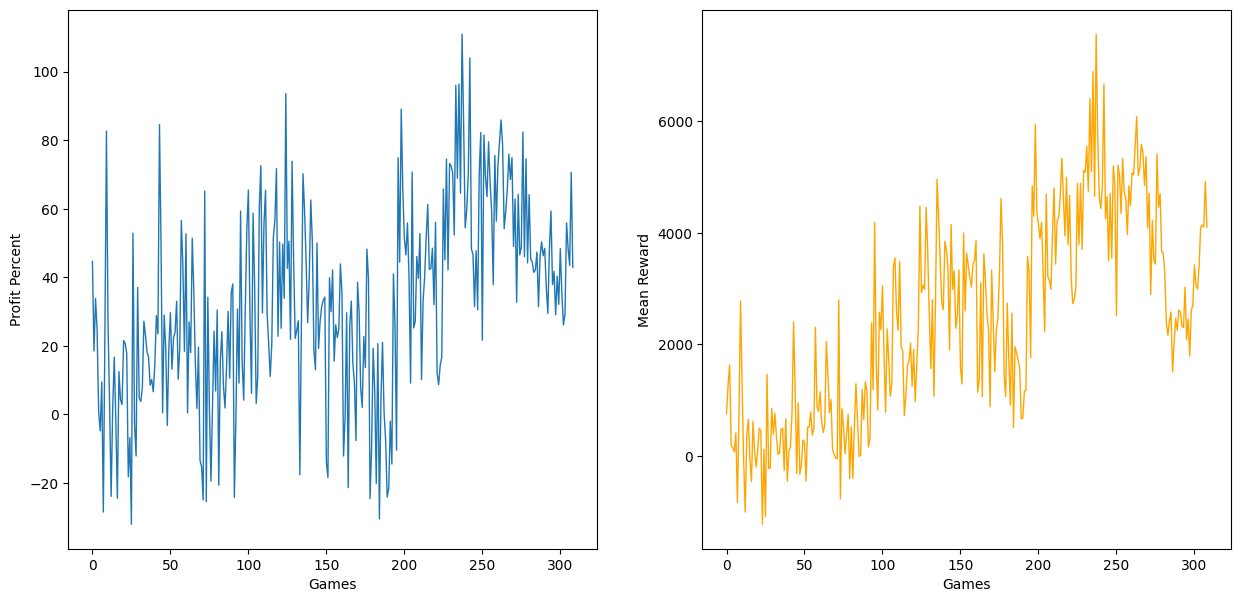

In [430]:
fig, ax=plt.subplots(1,2, figsize=(15,7))
ax[0].plot(np.array(plot_profit)*100,  linewidth=1) #profit as a percentage
ax[0].set(xlabel='Games', ylabel='Profit Percent')

ax[1].plot(plot_reward, linewidth=1, color='orange')
ax[1].set(xlabel='Games', ylabel='Mean Reward')

# ax[2].plot(plot_loss, linewidth=1, color='royalblue')
# ax[2].set(xlabel='Games', ylabel='Smooth L1 Loss')

## **Visualize Actions**, **Positive: BUY, Negative: SELL**

<ipython-input-431-fc683831dd6e>:16: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)


Text(0, 60, 'Game300')

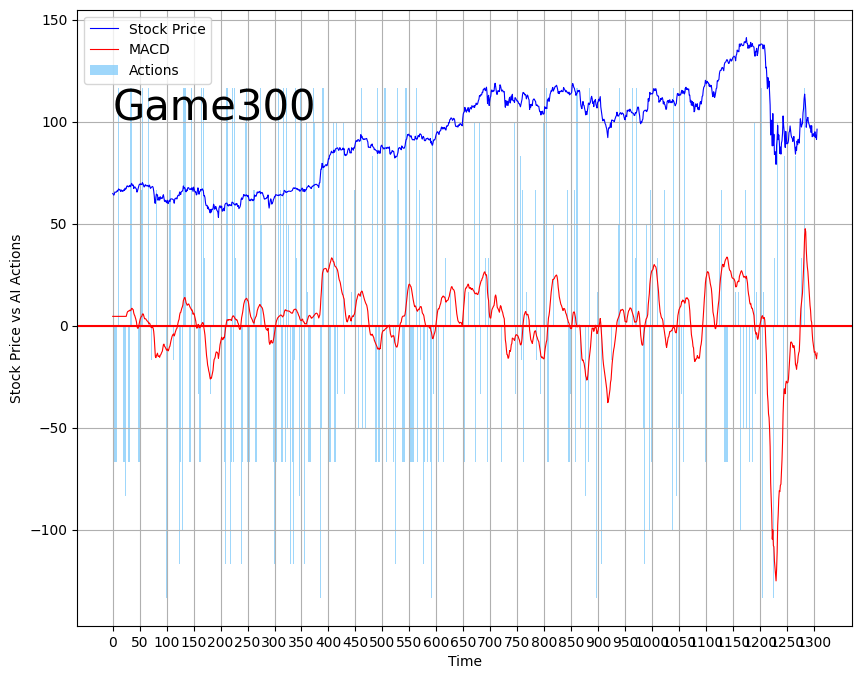

In [431]:
plt.figure(figsize=(10,8))
game_i=300 #input this to see actions in game i
game_length=stock_price_train.shape[0]-CONTEXT  #length of stock price
#visualize actions
plt.bar(x=np.arange(0,game_length), height=np.array(actions[game_length*game_i:game_length*(game_i+1)])/30, label='Actions', color='lightskyblue', alpha=0.8)
#plot stock price
plt.plot(stock_price_train, linewidth=0.8, color="blue", label='Stock Price')
plt.plot(stock_train[:,11]*10, linewidth=0.8, color="red", label='MACD')

plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xticks(np.arange(0,stock_price_train.shape[0],50))
plt.ylabel("Stock Price vs AI Actions")
plt.xlabel("Time")
plt.grid(True)
plt.legend()
plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)

### **Back Testing**

In [432]:
agent.n_games=5000
actions_test=[]
plot_profit_test=[]
plot_reward_test=[]
def test():
    rewards = []
    record = 0
    #create game on Testing set
    game = Game(w=CONTEXT, stock=stock_test, stock_price=stock_price_test, 
                 stock_delta=stock_delta_test, stock_pred_price=transformer_pred_test, pred_delta=pred_delta_test)
    epoch=6000 #a very large number just to keep the game running
    for i in tqdm( range(1,epoch+1) ):
        
        state_old = agent.get_state(game)
        action = agent.get_action(state_old, game)
        actions_test.append(action)
        
        reward, done= game.play_step(action)
#--------------------------------------------------------------------------------------------------------------------
        state_new = agent.get_state(game)

        rewards.append(reward)
        profit=game.profit

        if done:
            mean_reward=np.mean(rewards)
            plot_reward_test.append(mean_reward)
            rewards=[]
            game.reset()
            agent.n_games += 1
            if profit > record:
                record = profit

            print('Game', agent.n_games,"mean Reward", round(mean_reward,2), 'Profit', round(profit*100,2) ,'Record:', round(record*100,2), "eps",agent.epsilon)

            plot_profit.append(profit)



In [433]:
test()

 13%|█▎        | 763/6000 [00:01<00:08, 621.48it/s]

Game 5001 mean Reward 3374.02 Profit 48.33 Record: 48.33 eps 10


 24%|██▍       | 1465/6000 [00:02<00:07, 631.09it/s]

Game 5002 mean Reward 3503.43 Profit 62.61 Record: 62.61 eps 10


 36%|███▌      | 2164/6000 [00:03<00:06, 600.56it/s]

Game 5003 mean Reward 2878.27 Profit 50.84 Record: 62.61 eps 10


 47%|████▋     | 2813/6000 [00:04<00:06, 471.87it/s]

Game 5004 mean Reward 3129.66 Profit 50.63 Record: 62.61 eps 10


 59%|█████▉    | 3528/6000 [00:06<00:05, 437.12it/s]

Game 5005 mean Reward 2985.73 Profit 49.84 Record: 62.61 eps 10


 70%|███████   | 4228/6000 [00:07<00:03, 588.91it/s]

Game 5006 mean Reward 2764.76 Profit 46.39 Record: 62.61 eps 10


 82%|████████▏ | 4922/6000 [00:08<00:01, 605.55it/s]

Game 5007 mean Reward 3103.92 Profit 49.41 Record: 62.61 eps 10


 94%|█████████▎| 5622/6000 [00:09<00:00, 623.84it/s]

Game 5008 mean Reward 2823.23 Profit 42.74 Record: 62.61 eps 10


100%|██████████| 6000/6000 [00:10<00:00, 575.63it/s]


<ipython-input-435-10079c7f777a>:14: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)


Text(0, 60, 'Game1')

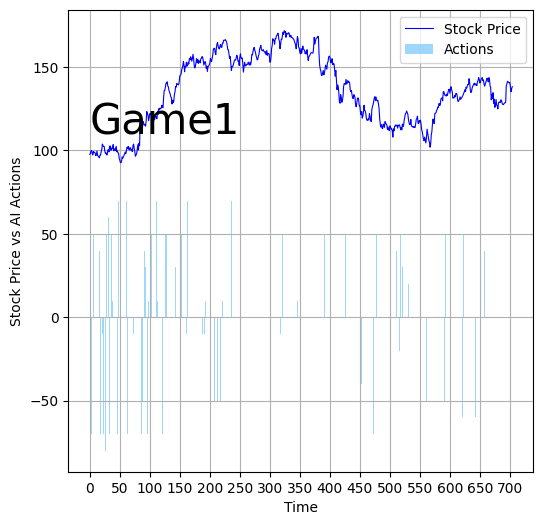

In [435]:
plt.figure(figsize=(6,6))
game_i=1 #input this to see actions in game i
game_length=stock_price_test.shape[0]-CONTEXT  #length of stock price
plt.bar(x=np.arange(0,game_length), height=np.array(actions_test[game_length*game_i:game_length*(game_i+1)])/50, label='Actions', color='lightskyblue', alpha=0.8)
#plot stock price
plt.plot(stock_price_test, linewidth=0.8, color="blue", label='Stock Price')

# plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xticks(np.arange(0,stock_price_test.shape[0],50))
plt.ylabel("Stock Price vs AI Actions")
plt.xlabel("Time")
plt.grid(True)
plt.legend()
plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)